# VLNCE+EnvDrop AUG
VLNCE 202779

VLNCE + AUG 601038 

In [1]:
import gc
import os,sys
os.chdir("/root/MLA/")
import random
import warnings
from collections import defaultdict
from datetime import datetime

import lmdb
import h5py
import msgpack_numpy
import numpy as np
import torch
from tqdm.notebook import tqdm
from habitat import logger
from habitat_baselines.common.baseline_registry import baseline_registry
from habitat_baselines.common.environments import get_env_class
from habitat_baselines.common.obs_transformers import (
    apply_obs_transforms_batch,
    apply_obs_transforms_obs_space,
    get_active_obs_transforms,
)
from habitat_baselines.common.tensorboard_utils import TensorboardWriter
from habitat_baselines.utils.common import batch_obs

from vlnce_baselines.common.aux_losses import AuxLosses
from vlnce_baselines.common.base_il_trainer import BaseVLNCETrainer
from vlnce_baselines.common.env_utils import construct_envs
from vlnce_baselines.common.utils import extract_instruction_tokens
from vlnce_baselines.config.default import get_config
def _pause_envs(
    envs_to_pause,
    envs,
    not_done_masks,
    prev_actions,
    batch,
    rgb_frames=None,
):
    # pausing envs with no new episode
    if len(envs_to_pause) > 0:
        state_index = list(range(envs.num_envs))
        for idx in reversed(envs_to_pause):
            state_index.pop(idx)
            envs.pause_at(idx)

        # indexing along the batch dimensions
        not_done_masks = not_done_masks[state_index]
        prev_actions = prev_actions[state_index]

        for k, v in batch.items():
            batch[k] = v[state_index]

        if rgb_frames is not None:
            rgb_frames = [rgb_frames[i] for i in state_index]

    return (
        envs,
        not_done_masks,
        prev_actions,
        batch,
        rgb_frames,
    )

## VLN-CE train

In [2]:
CONFIG = "/root/MLA/vlnce_baselines/config/transformer/transformer.yaml"

device = torch.device("cuda")
config = get_config(CONFIG)
envs = construct_envs(config, get_env_class(config.ENV_NAME))
expert_uuid = config.IL.DAGGER.expert_policy_sensor_uuid
prev_actions = torch.zeros(
    envs.num_envs,
    1,
    device=device,
    dtype=torch.long,
)
not_done_masks = torch.zeros(
    envs.num_envs, 1, dtype=torch.bool, device=device
)

observations = envs.reset()
observations = extract_instruction_tokens(
    observations, config.TASK_CONFIG.TASK.INSTRUCTION_SENSOR_UUID
)
batch = batch_obs(observations, device)
obs_transforms = get_active_obs_transforms(config)
batch = apply_obs_transforms_batch(batch, obs_transforms)

episodes = [[] for _ in range(envs.num_envs)]
skips = [False for _ in range(envs.num_envs)]
# Populate dones with False initially
dones = [False for _ in range(envs.num_envs)]

collected_eps = 0
ep_ids_collected = None
ensure_unique_episodes = True
if ensure_unique_episodes:
    ep_ids_collected = {
        ep.episode_id for ep in envs.current_episodes()
    }

2023-02-03 12:43:09,340 Initializing dataset VLN-CE-v1
2023-02-03 12:43:20,692 Initializing dataset VLN-CE-v1
2023-02-03 12:43:21,241 Initializing dataset VLN-CE-v1
2023-02-03 12:43:21,285 Initializing dataset VLN-CE-v1
2023-02-03 12:43:21,862 Initializing dataset VLN-CE-v1
2023-02-03 12:43:22,019 Initializing dataset VLN-CE-v1
2023-02-03 12:43:22,150 Initializing dataset VLN-CE-v1
2023-02-03 12:43:23,820 initializing sim Sim-v0
I0203 12:43:23.824206 3378598 ManagedFileBasedContainer.h:210] <Dataset>::convertFilenameToPassedExt : Filename : default changed to proposed scene_dataset_config.json filename : default.scene_dataset_config.json
I0203 12:43:23.824256 3378598 AttributesManagerBase.h:365] <Dataset>::createFromJsonOrDefaultInternal : Proposing JSON name : default.scene_dataset_config.json from original name : default | This file  does not exist.
I0203 12:43:23.824398 3378598 AssetAttributesManager.cpp:120] Asset attributes (capsule3DSolid : capsule3DSolid_hemiRings_4_cylRings_1_s

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits
Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
  

I0203 12:43:25.057209 3378601 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filename : data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.glb changed to proposed scene_instance.json filename : data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.scene_instance.json
I0203 12:43:25.057277 3378601 MetadataMediator.cpp:311] ::getSceneAttributesByName : Dataset : default has no preloaded SceneAttributes or StageAttributes named : data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.glb so loading/creating a new StageAttributes with this name, and then creating a SceneAttributes with the same name that references this stage.
I0203 12:43:25.057292 3378601 ManagedFileBasedContainer.h:210] <Stage Template>::convertFilenameToPassedExt : Filename : data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.glb changed to proposed stage_config.json filename : data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.stage_config.json
I0203 12:43:25.057305 3378601 AttributesManagerBase.h:365] 

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0203 12:43:25.306563 3378602 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filename : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb changed to proposed scene_instance.json filename : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.scene_instance.json
I0203 12:43:25.306625 3378602 MetadataMediator.cpp:311] ::getSceneAttributesByName : Dataset : default has no preloaded SceneAttributes or StageAttributes named : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb so loading/creating a new StageAttributes with this name, and then creating a SceneAttributes with the same name that references this stage.
I0203 12:43:25.306644 3378602 ManagedFileBasedContainer.h:210] <Stage Template>::convertFilenameToPassedExt : Filename : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb changed to proposed stage_config.json filename : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.stage_config.json
I0203 12:43:25.306659 3378602 AttributesManagerBase.h:365] 

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits
Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
  

I0203 12:43:26.818059 3378600 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filename : data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.glb changed to proposed scene_instance.json filename : data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.scene_instance.json
I0203 12:43:26.818100 3378600 MetadataMediator.cpp:311] ::getSceneAttributesByName : Dataset : default has no preloaded SceneAttributes or StageAttributes named : data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.glb so loading/creating a new StageAttributes with this name, and then creating a SceneAttributes with the same name that references this stage.
I0203 12:43:26.818110 3378600 ManagedFileBasedContainer.h:210] <Stage Template>::convertFilenameToPassedExt : Filename : data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.glb changed to proposed stage_config.json filename : data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.stage_config.json
I0203 12:43:26.818117 3378600 AttributesManagerBase.h:365] 

In [ ]:
RGB_SIZE = 224
DEPTH_SIZE = 256
SUB_LEN = 12
INST_LEN = 77
DOWNSAMPLE = 3
with tqdm(total=config.IL.DAGGER.update_size, dynamic_ncols=True) as pbar, h5py.File('/hy-tmp/stage2/data.mat','a') as t:
    if "rgb" in t:
        del t["rgb"]
    if "depth" in t:
        del t["depth"]
    target_rgb = t.create_dataset("rgb", shape=(0, RGB_SIZE, RGB_SIZE, 3), maxshape=(None, RGB_SIZE, RGB_SIZE, 3), dtype=np.uint8)
    target_depth = t.create_dataset("depth", shape=(0, DEPTH_SIZE, DEPTH_SIZE, 1), maxshape=(None, DEPTH_SIZE, DEPTH_SIZE, 1), dtype=float)
    if "instructions" in t:
        del t["instructions"]
    if "sub_instructions" in t:
        del t["sub_instructions"]
    target_inst = t.create_dataset("instructions", shape=(0, INST_LEN), maxshape=(None, INST_LEN), dtype=np.int32)
    target_sub = t.create_dataset("sub_instructions", shape=(0, SUB_LEN, INST_LEN), maxshape=(None, SUB_LEN, INST_LEN), dtype=np.int32)
    while collected_eps < config.IL.DAGGER.update_size:
        current_episodes = None
        envs_to_pause = None
        if ensure_unique_episodes:
            envs_to_pause = []
            current_episodes = envs.current_episodes()

        for i in range(envs.num_envs):
            if dones[i] and not skips[i]:
                ep = episodes[i]
                traj_obs = batch_obs(
                    [step[0] for step in ep],
                    device=torch.device("cpu"),
                )
                for k, v in traj_obs.items():
                    traj_obs[k] = v.numpy()
                    if config.IL.DAGGER.lmdb_fp16:
                        traj_obs[k] = traj_obs[k].astype(np.float16)

                rgbi = traj_obs["rgb"][::DOWNSAMPLE]
                depthi = traj_obs["depth"][::DOWNSAMPLE]
                insti = traj_obs["instruction"][::DOWNSAMPLE]
                subi = traj_obs["sub_instruction"][::DOWNSAMPLE]
                n = rgbi.shape[0]
                assert (depthi.shape[0]==n and insti.shape[0]==n and subi.shape[0]==n)
                target_rgb.resize(target_rgb.shape[0]+n, axis=0)
                target_rgb[-n:] = rgbi
                target_depth.resize(target_depth.shape[0]+n, axis=0)
                target_depth[-n:] = depthi
                target_inst.resize(target_inst.shape[0]+n, axis=0)
                target_inst[-n:] = insti
                target_sub.resize(target_sub.shape[0]+n, axis=0)
                target_sub[-n:] = subi

                pbar.update()
                collected_eps += 1

                if ensure_unique_episodes:
                    if (
                        current_episodes[i].episode_id
                        in ep_ids_collected
                    ):
                        envs_to_pause.append(i)
                    else:
                        ep_ids_collected.add(
                            current_episodes[i].episode_id
                        )
            if dones[i]:
                episodes[i] = []

        if ensure_unique_episodes:
            (
                envs,
                not_done_masks,
                prev_actions,
                batch,
                _,
            ) = _pause_envs(
                envs_to_pause,
                envs,
                not_done_masks,
                prev_actions,
                batch,
            )
            if envs.num_envs == 0:
                break

        actions = batch[expert_uuid].long()

        for i in range(envs.num_envs):
            episodes[i].append(
                (
                    observations[i],
                    prev_actions[i].item(),
                    batch[expert_uuid][i].item(),
                )
            )

        skips = batch[expert_uuid].long() == -1
        actions = torch.where(
            skips, torch.zeros_like(actions), actions
        )
        skips = skips.squeeze(-1)  # .to(device="cpu")
        prev_actions.copy_(actions)

        outputs = envs.step([a[0].item() for a in actions])
        observations, _, dones, _ = [list(x) for x in zip(*outputs)]

        observations = extract_instruction_tokens(
            observations,
            config.TASK_CONFIG.TASK.INSTRUCTION_SENSOR_UUID,
        )
        batch = batch_obs(observations, device)
        batch = apply_obs_transforms_batch(batch, obs_transforms)

        not_done_masks = torch.tensor(
            [[0] if done else [1] for done in dones],
            dtype=torch.uint8,
            device=device,
        )


envs.close()
envs = None


  0%|                                                                                                         …

(202779, 224, 224, 3)


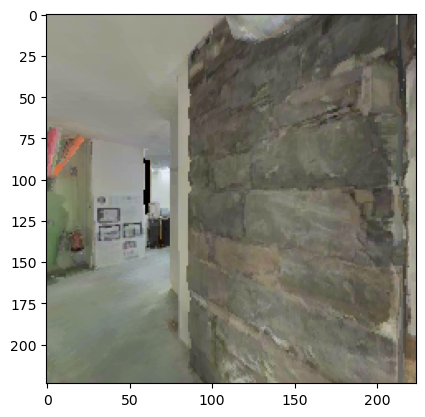

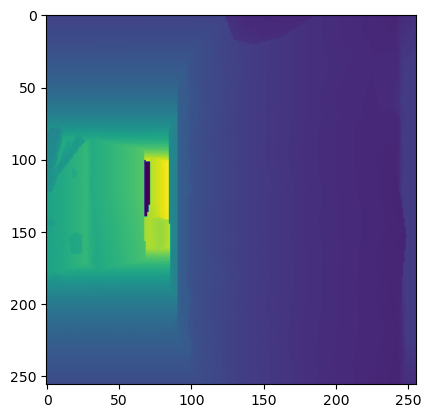

In [5]:
import matplotlib.pyplot as plt
with h5py.File('/hy-tmp/stage2/data.mat','r') as t:
    print(t["rgb"].shape)
    plt.figure()
    plt.imshow(t["rgb"][10000])
    plt.figure()
    plt.imshow(t["depth"][10000])
    # print(t["instructions"][10000])
    # print(t["sub_instructions"][10000])

In [40]:
import gzip
import json
with gzip.open("/root/MLA/data/datasets/R2R_VLNCE_NRSub_T/train/train_gt.json.gz", "r") as f:
    data = json.loads(f.read())

In [41]:
lens = []
for k,v in data.items():
    lens.append(v["forward_steps"])

In [42]:
import numpy as np
print(np.mean(lens))

37.73860800443664


In [6]:
30.0*10819

324570.0

In [38]:
len(data)

157232

In [20]:
157232 * 3

471696

2023-02-04 08:46:04,622 Worker KeyboardInterrupt
I0204 08:46:04.623366 3872519 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I0204 08:46:04.623453 3872519 SemanticScene.h:43] Deconstructing SemanticScene
2023-02-04 08:46:04,623 Worker KeyboardInterrupt
I0204 08:46:04.623711 3872520 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I0204 08:46:04.623823 3872520 SemanticScene.h:43] Deconstructing SemanticScene


## AUG

In [2]:
CONFIG = "/root/MLA/vlnce_baselines/config/transformer/transformer_aug.yaml"

device = torch.device("cuda")
config = get_config(CONFIG)
envs = construct_envs(config, get_env_class(config.ENV_NAME))
expert_uuid = config.IL.DAGGER.expert_policy_sensor_uuid
prev_actions = torch.zeros(
    envs.num_envs,
    1,
    device=device,
    dtype=torch.long,
)
not_done_masks = torch.zeros(
    envs.num_envs, 1, dtype=torch.bool, device=device
)

observations = envs.reset()
observations = extract_instruction_tokens(
    observations, config.TASK_CONFIG.TASK.INSTRUCTION_SENSOR_UUID
)
batch = batch_obs(observations, device)
obs_transforms = get_active_obs_transforms(config)
batch = apply_obs_transforms_batch(batch, obs_transforms)

episodes = [[] for _ in range(envs.num_envs)]
skips = [False for _ in range(envs.num_envs)]
# Populate dones with False initially
dones = [False for _ in range(envs.num_envs)]

collected_eps = 0
ep_ids_collected = None
ensure_unique_episodes = True
if ensure_unique_episodes:
    ep_ids_collected = {
        ep.episode_id for ep in envs.current_episodes()
    }

2023-02-04 15:23:51,871 Initializing dataset VLN-CE-v1
2023-02-04 15:24:41,432 Initializing dataset VLN-CE-v1
2023-02-04 15:24:41,512 Initializing dataset VLN-CE-v1
2023-02-04 15:24:41,607 Initializing dataset VLN-CE-v1
2023-02-04 15:24:42,010 Initializing dataset VLN-CE-v1
2023-02-04 15:24:42,019 Initializing dataset VLN-CE-v1
2023-02-04 15:24:42,634 Initializing dataset VLN-CE-v1
2023-02-04 15:25:27,379 initializing sim Sim-v0
I0204 15:25:27.384583 203769 ManagedFileBasedContainer.h:210] <Dataset>::convertFilenameToPassedExt : Filename : default changed to proposed scene_dataset_config.json filename : default.scene_dataset_config.json
I0204 15:25:27.384750 203769 AttributesManagerBase.h:365] <Dataset>::createFromJsonOrDefaultInternal : Proposing JSON name : default.scene_dataset_config.json from original name : default | This file  does not exist.
I0204 15:25:27.385016 203769 AssetAttributesManager.cpp:120] Asset attributes (capsule3DSolid : capsule3DSolid_hemiRings_4_cylRings_1_segm

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits
Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
  

I0204 15:25:28.907476 203769 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filename : data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb changed to proposed scene_instance.json filename : data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.scene_instance.json
I0204 15:25:28.907528 203769 MetadataMediator.cpp:311] ::getSceneAttributesByName : Dataset : default has no preloaded SceneAttributes or StageAttributes named : data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb so loading/creating a new StageAttributes with this name, and then creating a SceneAttributes with the same name that references this stage.
I0204 15:25:28.907542 203769 ManagedFileBasedContainer.h:210] <Stage Template>::convertFilenameToPassedExt : Filename : data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb changed to proposed stage_config.json filename : data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.stage_config.json
I0204 15:25:28.907554 203769 AttributesManagerBase.h:365] <Sta

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits
Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
  

I0204 15:25:34.499054 203768 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filename : data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.glb changed to proposed scene_instance.json filename : data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.scene_instance.json
I0204 15:25:34.499109 203768 MetadataMediator.cpp:311] ::getSceneAttributesByName : Dataset : default has no preloaded SceneAttributes or StageAttributes named : data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.glb so loading/creating a new StageAttributes with this name, and then creating a SceneAttributes with the same name that references this stage.
I0204 15:25:34.499120 203768 ManagedFileBasedContainer.h:210] <Stage Template>::convertFilenameToPassedExt : Filename : data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.glb changed to proposed stage_config.json filename : data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.stage_config.json
I0204 15:25:34.499130 203768 AttributesManagerBase.h:365] <Sta

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits
Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
  

I0204 15:25:37.202718 203776 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filename : data/scene_datasets/mp3d/8WUmhLawc2A/8WUmhLawc2A.glb changed to proposed scene_instance.json filename : data/scene_datasets/mp3d/8WUmhLawc2A/8WUmhLawc2A.scene_instance.json
I0204 15:25:37.202780 203776 MetadataMediator.cpp:311] ::getSceneAttributesByName : Dataset : default has no preloaded SceneAttributes or StageAttributes named : data/scene_datasets/mp3d/8WUmhLawc2A/8WUmhLawc2A.glb so loading/creating a new StageAttributes with this name, and then creating a SceneAttributes with the same name that references this stage.
I0204 15:25:37.202800 203776 ManagedFileBasedContainer.h:210] <Stage Template>::convertFilenameToPassedExt : Filename : data/scene_datasets/mp3d/8WUmhLawc2A/8WUmhLawc2A.glb changed to proposed stage_config.json filename : data/scene_datasets/mp3d/8WUmhLawc2A/8WUmhLawc2A.stage_config.json
I0204 15:25:37.202816 203776 AttributesManagerBase.h:365] <Sta

In [3]:
RGB_SIZE = 224
DEPTH_SIZE = 256
SUB_LEN = 12
INST_LEN = 77
DOWNSAMPLE = 10
with tqdm(total=config.IL.DAGGER.update_size, dynamic_ncols=True) as pbar, h5py.File('/hy-tmp/stage2/data.mat','a') as t:
    target_rgb = t["rgb"]
    target_depth = t["depth"]
    target_inst = t["instructions"]
    target_sub = t["sub_instructions"]
    while collected_eps < config.IL.DAGGER.update_size and target_rgb.shape[0]<601034:
        current_episodes = None
        envs_to_pause = None
        if ensure_unique_episodes:
            envs_to_pause = []
            current_episodes = envs.current_episodes()

        for i in range(envs.num_envs):
            if dones[i] and not skips[i]:
                ep = episodes[i]
                traj_obs = batch_obs(
                    [step[0] for step in ep],
                    device=torch.device("cpu"),
                )
                for k, v in traj_obs.items():
                    traj_obs[k] = v.numpy()
                    if config.IL.DAGGER.lmdb_fp16:
                        traj_obs[k] = traj_obs[k].astype(np.float16)

                rgbi = traj_obs["rgb"][::DOWNSAMPLE]
                depthi = traj_obs["depth"][::DOWNSAMPLE]
                insti = traj_obs["instruction"][::DOWNSAMPLE]
                subi = traj_obs["sub_instruction"][::DOWNSAMPLE]
                n = rgbi.shape[0]
                assert (depthi.shape[0]==n and insti.shape[0]==n and subi.shape[0]==n)
                target_rgb.resize(target_rgb.shape[0]+n, axis=0)
                target_rgb[-n:] = rgbi
                target_depth.resize(target_depth.shape[0]+n, axis=0)
                target_depth[-n:] = depthi
                target_inst.resize(target_inst.shape[0]+n, axis=0)
                target_inst[-n:] = insti
                target_sub.resize(target_sub.shape[0]+n, axis=0)
                target_sub[-n:] = subi

                pbar.update()
                collected_eps += 1

                if ensure_unique_episodes:
                    if (
                        current_episodes[i].episode_id
                        in ep_ids_collected
                    ):
                        envs_to_pause.append(i)
                    else:
                        ep_ids_collected.add(
                            current_episodes[i].episode_id
                        )
            if dones[i]:
                episodes[i] = []

        if ensure_unique_episodes:
            (
                envs,
                not_done_masks,
                prev_actions,
                batch,
                _,
            ) = _pause_envs(
                envs_to_pause,
                envs,
                not_done_masks,
                prev_actions,
                batch,
            )
            if envs.num_envs == 0:
                break

        actions = batch[expert_uuid].long()

        for i in range(envs.num_envs):
            episodes[i].append(
                (
                    observations[i],
                    prev_actions[i].item(),
                    batch[expert_uuid][i].item(),
                )
            )

        skips = batch[expert_uuid].long() == -1
        actions = torch.where(
            skips, torch.zeros_like(actions), actions
        )
        skips = skips.squeeze(-1)  # .to(device="cpu")
        prev_actions.copy_(actions)

        outputs = envs.step([a[0].item() for a in actions])
        observations, _, dones, _ = [list(x) for x in zip(*outputs)]

        observations = extract_instruction_tokens(
            observations,
            config.TASK_CONFIG.TASK.INSTRUCTION_SENSOR_UUID,
        )
        batch = batch_obs(observations, device)
        batch = apply_obs_transforms_batch(batch, obs_transforms)

        not_done_masks = torch.tensor(
            [[0] if done else [1] for done in dones],
            dtype=torch.uint8,
            device=device,
        )


envs.close()
envs = None


  0%|                                                                                                         …

I0204 15:49:28.308665 203776 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I0204 15:49:28.308781 203776 SemanticScene.h:43] Deconstructing SemanticScene
I0204 15:49:28.315380 203776 SceneManager.h:25] Deconstructing SceneManager
I0204 15:49:28.315405 203776 SceneGraph.h:25] Deconstructing SceneGraph
I0204 15:49:28.319136 203776 Sensor.cpp:69] Deconstructing Sensor
I0204 15:49:28.319234 203776 Sensor.cpp:69] Deconstructing Sensor
I0204 15:49:28.401021 203776 Renderer.cpp:71] Deconstructing Renderer
I0204 15:49:28.401059 203776 WindowlessContext.h:17] Deconstructing WindowlessContext
I0204 15:49:28.417901 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.glb and dataset : default which is currently active dataset.
I0204 15:49:28.426364 203776 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filename : data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3q

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 15:49:28.656611 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.house : exist : 0 : loaded as expected type : 1
I0204 15:49:28.657375 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 15:49:28.657397 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.glb and dataset : default which is currently active dataset.
I0204 15:49:28.657464 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.glb with render asset : data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.glb and collision asset : data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.glb
I0204 15:49:28.657496 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 15:50:44.010102 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.house : exist : 0 : loaded as expected type : 1
I0204 15:50:44.010699 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 15:50:44.010715 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb and dataset : default which is currently active dataset.
I0204 15:50:44.010766 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb with render asset : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb and collision asset : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb
I0204 15:50:44.010798 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 15:52:52.361300 203770 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb
W0204 15:52:52.361383 203770 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 15:52:52.361410 203770 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb yields 1 candidates.  Using data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb.
I0204 15:52:52.361447 203770 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb' specified in Scene Attributes exists in dataset library.
I0204 15:52:52.361454 203770 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 15:53:15.601888 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.house : exist : 0 : loaded as expected type : 1
I0204 15:53:15.603317 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 15:53:15.603339 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.glb and dataset : default which is currently active dataset.
I0204 15:53:15.603405 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.glb with render asset : data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.glb and collision asset : data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.glb
I0204 15:53:15.603446 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 15:55:43.282630 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.house : exist : 0 : loaded as expected type : 1
I0204 15:55:43.284286 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 15:55:43.284303 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.glb and dataset : default which is currently active dataset.
I0204 15:55:43.284350 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.glb with render asset : data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.glb and collision asset : data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.glb
I0204 15:55:43.284379 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 15:57:33.966529 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/Uxmj2M2itWa/Uxmj2M2itWa.house : exist : 0 : loaded as expected type : 1
I0204 15:57:33.967070 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 15:57:33.967088 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/Uxmj2M2itWa/Uxmj2M2itWa.glb and dataset : default which is currently active dataset.
I0204 15:57:33.967155 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/Uxmj2M2itWa/Uxmj2M2itWa.glb with render asset : data/scene_datasets/mp3d/Uxmj2M2itWa/Uxmj2M2itWa.glb and collision asset : data/scene_datasets/mp3d/Uxmj2M2itWa/Uxmj2M2itWa.glb
I0204 15:57:33.967192 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 16:13:32.844122 203769 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filename : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb changed to proposed scene_instance.json filename : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.scene_instance.json
I0204 16:13:32.844223 203769 MetadataMediator.cpp:311] ::getSceneAttributesByName : Dataset : default has no preloaded SceneAttributes or StageAttributes named : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb so loading/creating a new StageAttributes with this name, and then creating a SceneAttributes with the same name that references this stage.
I0204 16:13:32.844261 203769 ManagedFileBasedContainer.h:210] <Stage Template>::convertFilenameToPassedExt : Filename : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb changed to proposed stage_config.json filename : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.stage_config.json
I0204 16:13:32.844280 203769 AttributesManagerBase.h:365] <Sta

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 16:19:06.104435 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/pRbA3pwrgk9/pRbA3pwrgk9.house : exist : 0 : loaded as expected type : 1
I0204 16:19:06.105281 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 16:19:06.105300 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/pRbA3pwrgk9/pRbA3pwrgk9.glb and dataset : default which is currently active dataset.
I0204 16:19:06.105350 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/pRbA3pwrgk9/pRbA3pwrgk9.glb with render asset : data/scene_datasets/mp3d/pRbA3pwrgk9/pRbA3pwrgk9.glb and collision asset : data/scene_datasets/mp3d/pRbA3pwrgk9/pRbA3pwrgk9.glb
I0204 16:19:06.105383 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 16:20:24.239277 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.house : exist : 0 : loaded as expected type : 1
I0204 16:20:24.240006 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 16:20:24.240023 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.glb and dataset : default which is currently active dataset.
I0204 16:20:24.240106 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.glb with render asset : data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.glb and collision asset : data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.glb
I0204 16:20:24.240144 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 16:20:51.625689 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.house : exist : 0 : loaded as expected type : 1
I0204 16:20:51.627216 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 16:20:51.627235 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.glb and dataset : default which is currently active dataset.
I0204 16:20:51.627290 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.glb with render asset : data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.glb and collision asset : data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.glb
I0204 16:20:51.627321 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 16:21:51.173943 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/e9zR4mvMWw7/e9zR4mvMWw7.house : exist : 0 : loaded as expected type : 1
I0204 16:21:51.174887 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 16:21:51.174911 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/e9zR4mvMWw7/e9zR4mvMWw7.glb and dataset : default which is currently active dataset.
I0204 16:21:51.174990 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/e9zR4mvMWw7/e9zR4mvMWw7.glb with render asset : data/scene_datasets/mp3d/e9zR4mvMWw7/e9zR4mvMWw7.glb and collision asset : data/scene_datasets/mp3d/e9zR4mvMWw7/e9zR4mvMWw7.glb
I0204 16:21:51.175043 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 16:24:19.098417 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.house : exist : 0 : loaded as expected type : 1
I0204 16:24:19.099316 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 16:24:19.099332 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.glb and dataset : default which is currently active dataset.
I0204 16:24:19.099388 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.glb with render asset : data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.glb and collision asset : data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.glb
I0204 16:24:19.099424 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 16:32:27.400766 203769 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb
W0204 16:32:27.400851 203769 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 16:32:27.400883 203769 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb yields 1 candidates.  Using data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb.
I0204 16:32:27.400925 203769 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb' specified in Scene Attributes exists in dataset library.
I0204 16:32:27.400933 203769 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 16:34:41.252215 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.house : exist : 0 : loaded as expected type : 1
I0204 16:34:41.254070 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 16:34:41.254091 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.glb and dataset : default which is currently active dataset.
I0204 16:34:41.254161 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.glb with render asset : data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.glb and collision asset : data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.glb
I0204 16:34:41.254216 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 16:36:08.998705 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.house : exist : 0 : loaded as expected type : 1
I0204 16:36:09.002033 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 16:36:09.002068 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.glb and dataset : default which is currently active dataset.
I0204 16:36:09.002138 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.glb with render asset : data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.glb and collision asset : data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.glb
I0204 16:36:09.002172 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 16:36:48.060017 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.house : exist : 0 : loaded as expected type : 1
I0204 16:36:48.061733 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 16:36:48.061758 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.glb and dataset : default which is currently active dataset.
I0204 16:36:48.061815 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.glb with render asset : data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.glb and collision asset : data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.glb
I0204 16:36:48.061849 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 16:37:23.016144 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.house : exist : 0 : loaded as expected type : 1
I0204 16:37:23.018559 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 16:37:23.018589 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.glb and dataset : default which is currently active dataset.
I0204 16:37:23.018688 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.glb with render asset : data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.glb and collision asset : data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.glb
I0204 16:37:23.018728 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 16:40:15.215608 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.house : exist : 0 : loaded as expected type : 1
I0204 16:40:15.217062 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 16:40:15.217082 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.glb and dataset : default which is currently active dataset.
I0204 16:40:15.217135 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.glb with render asset : data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.glb and collision asset : data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.glb
I0204 16:40:15.217170 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 16:57:14.138999 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/VVfe2KiqLaN/VVfe2KiqLaN.house : exist : 0 : loaded as expected type : 1
I0204 16:57:14.139904 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 16:57:14.139921 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/VVfe2KiqLaN/VVfe2KiqLaN.glb and dataset : default which is currently active dataset.
I0204 16:57:14.139979 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/VVfe2KiqLaN/VVfe2KiqLaN.glb with render asset : data/scene_datasets/mp3d/VVfe2KiqLaN/VVfe2KiqLaN.glb and collision asset : data/scene_datasets/mp3d/VVfe2KiqLaN/VVfe2KiqLaN.glb
I0204 16:57:14.140033 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 16:59:00.776093 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/82sE5b5pLXE/82sE5b5pLXE.house : exist : 0 : loaded as expected type : 1
I0204 16:59:00.776618 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 16:59:00.776635 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/82sE5b5pLXE/82sE5b5pLXE.glb and dataset : default which is currently active dataset.
I0204 16:59:00.776700 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/82sE5b5pLXE/82sE5b5pLXE.glb with render asset : data/scene_datasets/mp3d/82sE5b5pLXE/82sE5b5pLXE.glb and collision asset : data/scene_datasets/mp3d/82sE5b5pLXE/82sE5b5pLXE.glb
I0204 16:59:00.776760 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 17:00:10.426800 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.house : exist : 0 : loaded as expected type : 1
I0204 17:00:10.429061 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 17:00:10.429100 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.glb and dataset : default which is currently active dataset.
I0204 17:00:10.429210 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.glb with render asset : data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.glb and collision asset : data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.glb
I0204 17:00:10.429275 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 17:01:06.745965 203768 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/ZMojNkEp431/ZMojNkEp431.glb
W0204 17:01:06.746058 203768 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 17:01:06.746093 203768 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/ZMojNkEp431/ZMojNkEp431.glb yields 1 candidates.  Using data/scene_datasets/mp3d/ZMojNkEp431/ZMojNkEp431.glb.
I0204 17:01:06.746142 203768 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/ZMojNkEp431/ZMojNkEp431.glb' specified in Scene Attributes exists in dataset library.
I0204 17:01:06.746152 203768 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 17:05:34.402052 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.house : exist : 0 : loaded as expected type : 1
I0204 17:05:34.402896 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 17:05:34.402915 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.glb and dataset : default which is currently active dataset.
I0204 17:05:34.402971 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.glb with render asset : data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.glb and collision asset : data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.glb
I0204 17:05:34.403019 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 17:06:06.756619 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.house : exist : 0 : loaded as expected type : 1
I0204 17:06:06.757685 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 17:06:06.757699 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.glb and dataset : default which is currently active dataset.
I0204 17:06:06.757757 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.glb with render asset : data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.glb and collision asset : data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.glb
I0204 17:06:06.757791 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 17:11:26.952688 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.house : exist : 0 : loaded as expected type : 1
I0204 17:11:26.953692 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 17:11:26.953711 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb and dataset : default which is currently active dataset.
I0204 17:11:26.953765 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb with render asset : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb and collision asset : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb
I0204 17:11:26.953816 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 17:13:30.540369 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.house : exist : 0 : loaded as expected type : 1
I0204 17:13:30.541669 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 17:13:30.541687 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.glb and dataset : default which is currently active dataset.
I0204 17:13:30.541743 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.glb with render asset : data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.glb and collision asset : data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.glb
I0204 17:13:30.541783 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 17:13:59.949661 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/759xd9YjKW5/759xd9YjKW5.house : exist : 0 : loaded as expected type : 1
I0204 17:13:59.950826 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 17:13:59.950862 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/759xd9YjKW5/759xd9YjKW5.glb and dataset : default which is currently active dataset.
I0204 17:13:59.950939 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/759xd9YjKW5/759xd9YjKW5.glb with render asset : data/scene_datasets/mp3d/759xd9YjKW5/759xd9YjKW5.glb and collision asset : data/scene_datasets/mp3d/759xd9YjKW5/759xd9YjKW5.glb
I0204 17:13:59.950976 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 17:14:33.036675 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/Vvot9Ly1tCj/Vvot9Ly1tCj.house : exist : 0 : loaded as expected type : 1
I0204 17:14:33.037423 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 17:14:33.037441 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/Vvot9Ly1tCj/Vvot9Ly1tCj.glb and dataset : default which is currently active dataset.
I0204 17:14:33.037490 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/Vvot9Ly1tCj/Vvot9Ly1tCj.glb with render asset : data/scene_datasets/mp3d/Vvot9Ly1tCj/Vvot9Ly1tCj.glb and collision asset : data/scene_datasets/mp3d/Vvot9Ly1tCj/Vvot9Ly1tCj.glb
I0204 17:14:33.037528 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 17:15:20.273317 203768 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/r1Q1Z4BcV1o/r1Q1Z4BcV1o.glb
W0204 17:15:20.273404 203768 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 17:15:20.273434 203768 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/r1Q1Z4BcV1o/r1Q1Z4BcV1o.glb yields 1 candidates.  Using data/scene_datasets/mp3d/r1Q1Z4BcV1o/r1Q1Z4BcV1o.glb.
I0204 17:15:20.273478 203768 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/r1Q1Z4BcV1o/r1Q1Z4BcV1o.glb' specified in Scene Attributes exists in dataset library.
I0204 17:15:20.273483 203768 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 17:16:16.373662 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.house : exist : 0 : loaded as expected type : 1
I0204 17:16:16.374626 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 17:16:16.374642 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.glb and dataset : default which is currently active dataset.
I0204 17:16:16.374696 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.glb with render asset : data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.glb and collision asset : data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.glb
I0204 17:16:16.374725 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 17:19:40.907790 203769 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/aayBHfsNo7d/aayBHfsNo7d.glb
W0204 17:19:40.907855 203769 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 17:19:40.907878 203769 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/aayBHfsNo7d/aayBHfsNo7d.glb yields 1 candidates.  Using data/scene_datasets/mp3d/aayBHfsNo7d/aayBHfsNo7d.glb.
I0204 17:19:40.907912 203769 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/aayBHfsNo7d/aayBHfsNo7d.glb' specified in Scene Attributes exists in dataset library.
I0204 17:19:40.907918 203769 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 17:23:40.967605 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/JmbYfDe2QKZ/JmbYfDe2QKZ.house : exist : 0 : loaded as expected type : 1
I0204 17:23:40.968571 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 17:23:40.968590 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/JmbYfDe2QKZ/JmbYfDe2QKZ.glb and dataset : default which is currently active dataset.
I0204 17:23:40.968644 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/JmbYfDe2QKZ/JmbYfDe2QKZ.glb with render asset : data/scene_datasets/mp3d/JmbYfDe2QKZ/JmbYfDe2QKZ.glb and collision asset : data/scene_datasets/mp3d/JmbYfDe2QKZ/JmbYfDe2QKZ.glb
I0204 17:23:40.968685 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 17:24:03.540767 203773 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/jh4fc5c5qoQ/jh4fc5c5qoQ.glb
W0204 17:24:03.540833 203773 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 17:24:03.540863 203773 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/jh4fc5c5qoQ/jh4fc5c5qoQ.glb yields 1 candidates.  Using data/scene_datasets/mp3d/jh4fc5c5qoQ/jh4fc5c5qoQ.glb.
I0204 17:24:03.540889 203773 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/jh4fc5c5qoQ/jh4fc5c5qoQ.glb' specified in Scene Attributes exists in dataset library.
I0204 17:24:03.540895 203773 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 17:24:42.815979 203766 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/29hnd4uzFmX/29hnd4uzFmX.glb
W0204 17:24:42.816054 203766 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 17:24:42.816085 203766 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/29hnd4uzFmX/29hnd4uzFmX.glb yields 1 candidates.  Using data/scene_datasets/mp3d/29hnd4uzFmX/29hnd4uzFmX.glb.
I0204 17:24:42.816118 203766 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/29hnd4uzFmX/29hnd4uzFmX.glb' specified in Scene Attributes exists in dataset library.
I0204 17:24:42.816124 203766 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 17:25:52.750098 203768 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/i5noydFURQK/i5noydFURQK.glb
W0204 17:25:52.750154 203768 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 17:25:52.750169 203768 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/i5noydFURQK/i5noydFURQK.glb yields 1 candidates.  Using data/scene_datasets/mp3d/i5noydFURQK/i5noydFURQK.glb.
I0204 17:25:52.750187 203768 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/i5noydFURQK/i5noydFURQK.glb' specified in Scene Attributes exists in dataset library.
I0204 17:25:52.750192 203768 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 17:25:54.923624 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.house : exist : 0 : loaded as expected type : 1
I0204 17:25:54.924459 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 17:25:54.924480 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.glb and dataset : default which is currently active dataset.
I0204 17:25:54.924536 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.glb with render asset : data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.glb and collision asset : data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.glb
I0204 17:25:54.924573 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 17:28:34.533311 203769 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/s8pcmisQ38h/s8pcmisQ38h.glb
W0204 17:28:34.533389 203769 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 17:28:34.533423 203769 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/s8pcmisQ38h/s8pcmisQ38h.glb yields 1 candidates.  Using data/scene_datasets/mp3d/s8pcmisQ38h/s8pcmisQ38h.glb.
I0204 17:28:34.533463 203769 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/s8pcmisQ38h/s8pcmisQ38h.glb' specified in Scene Attributes exists in dataset library.
I0204 17:28:34.533468 203769 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 17:30:46.874871 203776 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/cV4RVeZvu5T/cV4RVeZvu5T.glb
W0204 17:30:46.874956 203776 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 17:30:46.874994 203776 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/cV4RVeZvu5T/cV4RVeZvu5T.glb yields 1 candidates.  Using data/scene_datasets/mp3d/cV4RVeZvu5T/cV4RVeZvu5T.glb.
I0204 17:30:46.875042 203776 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/cV4RVeZvu5T/cV4RVeZvu5T.glb' specified in Scene Attributes exists in dataset library.
I0204 17:30:46.875049 203776 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 17:31:44.133512 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/sT4fr6TAbpF/sT4fr6TAbpF.house : exist : 0 : loaded as expected type : 1
I0204 17:31:44.134045 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 17:31:44.134063 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/sT4fr6TAbpF/sT4fr6TAbpF.glb and dataset : default which is currently active dataset.
I0204 17:31:44.134120 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/sT4fr6TAbpF/sT4fr6TAbpF.glb with render asset : data/scene_datasets/mp3d/sT4fr6TAbpF/sT4fr6TAbpF.glb and collision asset : data/scene_datasets/mp3d/sT4fr6TAbpF/sT4fr6TAbpF.glb
I0204 17:31:44.134153 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 17:33:06.589116 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.house : exist : 0 : loaded as expected type : 1
I0204 17:33:06.590364 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 17:33:06.590387 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.glb and dataset : default which is currently active dataset.
I0204 17:33:06.590454 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.glb with render asset : data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.glb and collision asset : data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.glb
I0204 17:33:06.590488 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 17:34:04.752887 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.house : exist : 0 : loaded as expected type : 1
I0204 17:34:04.753391 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 17:34:04.753409 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.glb and dataset : default which is currently active dataset.
I0204 17:34:04.753461 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.glb with render asset : data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.glb and collision asset : data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.glb
I0204 17:34:04.753497 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 17:34:48.794942 203770 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/17DRP5sb8fy/17DRP5sb8fy.glb
W0204 17:34:48.794996 203770 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 17:34:48.795019 203770 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/17DRP5sb8fy/17DRP5sb8fy.glb yields 1 candidates.  Using data/scene_datasets/mp3d/17DRP5sb8fy/17DRP5sb8fy.glb.
I0204 17:34:48.795042 203770 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/17DRP5sb8fy/17DRP5sb8fy.glb' specified in Scene Attributes exists in dataset library.
I0204 17:34:48.795048 203770 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 17:37:15.515745 203769 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/Pm6F8kyY3z2/Pm6F8kyY3z2.glb
W0204 17:37:15.515816 203769 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 17:37:15.515843 203769 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/Pm6F8kyY3z2/Pm6F8kyY3z2.glb yields 1 candidates.  Using data/scene_datasets/mp3d/Pm6F8kyY3z2/Pm6F8kyY3z2.glb.
I0204 17:37:15.515874 203769 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/Pm6F8kyY3z2/Pm6F8kyY3z2.glb' specified in Scene Attributes exists in dataset library.
I0204 17:37:15.515879 203769 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 17:40:39.933832 203773 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/PuKPg4mmafe/PuKPg4mmafe.glb
W0204 17:40:39.933926 203773 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 17:40:39.933960 203773 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/PuKPg4mmafe/PuKPg4mmafe.glb yields 1 candidates.  Using data/scene_datasets/mp3d/PuKPg4mmafe/PuKPg4mmafe.glb.
I0204 17:40:39.934002 203773 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/PuKPg4mmafe/PuKPg4mmafe.glb' specified in Scene Attributes exists in dataset library.
I0204 17:40:39.934008 203773 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 17:40:43.748771 203776 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/EDJbREhghzL/EDJbREhghzL.glb
W0204 17:40:43.748857 203776 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 17:40:43.748899 203776 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/EDJbREhghzL/EDJbREhghzL.glb yields 1 candidates.  Using data/scene_datasets/mp3d/EDJbREhghzL/EDJbREhghzL.glb.
I0204 17:40:43.748940 203776 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/EDJbREhghzL/EDJbREhghzL.glb' specified in Scene Attributes exists in dataset library.
I0204 17:40:43.748947 203776 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 17:41:01.971771 203766 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/5q7pvUzZiYa/5q7pvUzZiYa.glb
W0204 17:41:01.971863 203766 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 17:41:01.971901 203766 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/5q7pvUzZiYa/5q7pvUzZiYa.glb yields 1 candidates.  Using data/scene_datasets/mp3d/5q7pvUzZiYa/5q7pvUzZiYa.glb.
I0204 17:41:01.971940 203766 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/5q7pvUzZiYa/5q7pvUzZiYa.glb' specified in Scene Attributes exists in dataset library.
I0204 17:41:01.971946 203766 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 17:44:16.625556 203768 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/S9hNv5qa7GM/S9hNv5qa7GM.glb
W0204 17:44:16.625649 203768 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 17:44:16.625689 203768 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/S9hNv5qa7GM/S9hNv5qa7GM.glb yields 1 candidates.  Using data/scene_datasets/mp3d/S9hNv5qa7GM/S9hNv5qa7GM.glb.
I0204 17:44:16.625737 203768 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/S9hNv5qa7GM/S9hNv5qa7GM.glb' specified in Scene Attributes exists in dataset library.
I0204 17:44:16.625744 203768 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 17:44:37.285301 203770 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/D7G3Y4RVNrH/D7G3Y4RVNrH.glb
W0204 17:44:37.285353 203770 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 17:44:37.285372 203770 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/D7G3Y4RVNrH/D7G3Y4RVNrH.glb yields 1 candidates.  Using data/scene_datasets/mp3d/D7G3Y4RVNrH/D7G3Y4RVNrH.glb.
I0204 17:44:37.285399 203770 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/D7G3Y4RVNrH/D7G3Y4RVNrH.glb' specified in Scene Attributes exists in dataset library.
I0204 17:44:37.285405 203770 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 17:44:50.074838 203769 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/JF19kD82Mey/JF19kD82Mey.glb
W0204 17:44:50.074904 203769 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 17:44:50.074929 203769 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/JF19kD82Mey/JF19kD82Mey.glb yields 1 candidates.  Using data/scene_datasets/mp3d/JF19kD82Mey/JF19kD82Mey.glb.
I0204 17:44:50.074960 203769 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/JF19kD82Mey/JF19kD82Mey.glb' specified in Scene Attributes exists in dataset library.
I0204 17:44:50.074965 203769 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 17:47:39.987963 203776 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/HxpKQynjfin/HxpKQynjfin.glb
W0204 17:47:39.988046 203776 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 17:47:39.988092 203776 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/HxpKQynjfin/HxpKQynjfin.glb yields 1 candidates.  Using data/scene_datasets/mp3d/HxpKQynjfin/HxpKQynjfin.glb.
I0204 17:47:39.988170 203776 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/HxpKQynjfin/HxpKQynjfin.glb' specified in Scene Attributes exists in dataset library.
I0204 17:47:39.988183 203776 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 17:49:00.413445 203773 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/GdvgFV5R1Z5/GdvgFV5R1Z5.glb
W0204 17:49:00.413501 203773 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 17:49:00.413520 203773 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/GdvgFV5R1Z5/GdvgFV5R1Z5.glb yields 1 candidates.  Using data/scene_datasets/mp3d/GdvgFV5R1Z5/GdvgFV5R1Z5.glb.
I0204 17:49:00.413538 203773 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/GdvgFV5R1Z5/GdvgFV5R1Z5.glb' specified in Scene Attributes exists in dataset library.
I0204 17:49:00.413543 203773 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 17:49:13.156621 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/VLzqgDo317F/VLzqgDo317F.house : exist : 0 : loaded as expected type : 1
I0204 17:49:13.157390 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 17:49:13.157408 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/VLzqgDo317F/VLzqgDo317F.glb and dataset : default which is currently active dataset.
I0204 17:49:13.157465 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/VLzqgDo317F/VLzqgDo317F.glb with render asset : data/scene_datasets/mp3d/VLzqgDo317F/VLzqgDo317F.glb and collision asset : data/scene_datasets/mp3d/VLzqgDo317F/VLzqgDo317F.glb
I0204 17:49:13.157497 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 17:50:46.949823 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.house : exist : 0 : loaded as expected type : 1
I0204 17:50:46.951673 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 17:50:46.951694 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.glb and dataset : default which is currently active dataset.
I0204 17:50:46.951758 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.glb with render asset : data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.glb and collision asset : data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.glb
I0204 17:50:46.951788 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 17:52:23.133744 203776 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/8WUmhLawc2A/8WUmhLawc2A.glb
W0204 17:52:23.133842 203776 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 17:52:23.133898 203776 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/8WUmhLawc2A/8WUmhLawc2A.glb yields 1 candidates.  Using data/scene_datasets/mp3d/8WUmhLawc2A/8WUmhLawc2A.glb.
I0204 17:52:23.133953 203776 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/8WUmhLawc2A/8WUmhLawc2A.glb' specified in Scene Attributes exists in dataset library.
I0204 17:52:23.133960 203776 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 17:52:30.904150 203770 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/XcA2TqTSSAj/XcA2TqTSSAj.glb
W0204 17:52:30.904237 203770 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 17:52:30.904275 203770 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/XcA2TqTSSAj/XcA2TqTSSAj.glb yields 1 candidates.  Using data/scene_datasets/mp3d/XcA2TqTSSAj/XcA2TqTSSAj.glb.
I0204 17:52:30.904318 203770 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/XcA2TqTSSAj/XcA2TqTSSAj.glb' specified in Scene Attributes exists in dataset library.
I0204 17:52:30.904325 203770 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 17:52:47.957538 203768 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/YmJkqBEsHnH/YmJkqBEsHnH.glb
W0204 17:52:47.957623 203768 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 17:52:47.957672 203768 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/YmJkqBEsHnH/YmJkqBEsHnH.glb yields 1 candidates.  Using data/scene_datasets/mp3d/YmJkqBEsHnH/YmJkqBEsHnH.glb.
I0204 17:52:47.957722 203768 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/YmJkqBEsHnH/YmJkqBEsHnH.glb' specified in Scene Attributes exists in dataset library.
I0204 17:52:47.957731 203768 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 17:54:40.139313 203769 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb
W0204 17:54:40.139371 203769 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 17:54:40.139400 203769 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb yields 1 candidates.  Using data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb.
I0204 17:54:40.139422 203769 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb' specified in Scene Attributes exists in dataset library.
I0204 17:54:40.139427 203769 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 17:54:57.232695 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.house : exist : 0 : loaded as expected type : 1
I0204 17:54:57.233490 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 17:54:57.233507 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.glb and dataset : default which is currently active dataset.
I0204 17:54:57.233613 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.glb with render asset : data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.glb and collision asset : data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.glb
I0204 17:54:57.233652 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 17:59:59.418416 203766 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/gZ6f7yhEvPG/gZ6f7yhEvPG.glb
W0204 17:59:59.418465 203766 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 17:59:59.418484 203766 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/gZ6f7yhEvPG/gZ6f7yhEvPG.glb yields 1 candidates.  Using data/scene_datasets/mp3d/gZ6f7yhEvPG/gZ6f7yhEvPG.glb.
I0204 17:59:59.418504 203766 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/gZ6f7yhEvPG/gZ6f7yhEvPG.glb' specified in Scene Attributes exists in dataset library.
I0204 17:59:59.418509 203766 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 18:00:05.112864 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/kEZ7cmS4wCh/kEZ7cmS4wCh.house : exist : 0 : loaded as expected type : 1
I0204 18:00:05.113526 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 18:00:05.113548 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/kEZ7cmS4wCh/kEZ7cmS4wCh.glb and dataset : default which is currently active dataset.
I0204 18:00:05.113641 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/kEZ7cmS4wCh/kEZ7cmS4wCh.glb with render asset : data/scene_datasets/mp3d/kEZ7cmS4wCh/kEZ7cmS4wCh.glb and collision asset : data/scene_datasets/mp3d/kEZ7cmS4wCh/kEZ7cmS4wCh.glb
I0204 18:00:05.113675 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 18:00:14.295827 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.house : exist : 0 : loaded as expected type : 1
I0204 18:00:14.297099 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 18:00:14.297117 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.glb and dataset : default which is currently active dataset.
I0204 18:00:14.297271 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.glb with render asset : data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.glb and collision asset : data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.glb
I0204 18:00:14.297307 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 18:01:35.105111 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.house : exist : 0 : loaded as expected type : 1
I0204 18:01:35.105818 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 18:01:35.105835 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.glb and dataset : default which is currently active dataset.
I0204 18:01:35.105949 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.glb with render asset : data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.glb and collision asset : data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.glb
I0204 18:01:35.105984 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 18:03:00.964622 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.house : exist : 0 : loaded as expected type : 1
I0204 18:03:00.965479 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 18:03:00.965498 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.glb and dataset : default which is currently active dataset.
I0204 18:03:00.965597 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.glb with render asset : data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.glb and collision asset : data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.glb
I0204 18:03:00.965637 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 18:04:16.716032 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.house : exist : 0 : loaded as expected type : 1
I0204 18:04:16.716643 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 18:04:16.716677 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.glb and dataset : default which is currently active dataset.
I0204 18:04:16.716756 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.glb with render asset : data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.glb and collision asset : data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.glb
I0204 18:04:16.716802 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 18:04:39.636155 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.house : exist : 0 : loaded as expected type : 1
I0204 18:04:39.636644 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 18:04:39.636670 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb and dataset : default which is currently active dataset.
I0204 18:04:39.636768 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb with render asset : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb and collision asset : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb
I0204 18:04:39.636814 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 18:07:33.884073 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.house : exist : 0 : loaded as expected type : 1
I0204 18:07:33.884629 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 18:07:33.884644 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.glb and dataset : default which is currently active dataset.
I0204 18:07:33.884758 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.glb with render asset : data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.glb and collision asset : data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.glb
I0204 18:07:33.884860 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 18:08:52.799640 203766 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/Uxmj2M2itWa/Uxmj2M2itWa.glb
W0204 18:08:52.799701 203766 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 18:08:52.799734 203766 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/Uxmj2M2itWa/Uxmj2M2itWa.glb yields 1 candidates.  Using data/scene_datasets/mp3d/Uxmj2M2itWa/Uxmj2M2itWa.glb.
I0204 18:08:52.799770 203766 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/Uxmj2M2itWa/Uxmj2M2itWa.glb' specified in Scene Attributes exists in dataset library.
I0204 18:08:52.799777 203766 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 18:10:36.960346 203770 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb
W0204 18:10:36.960412 203770 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 18:10:36.960443 203770 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb yields 1 candidates.  Using data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb.
I0204 18:10:36.960469 203770 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb' specified in Scene Attributes exists in dataset library.
I0204 18:10:36.960475 203770 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 18:10:48.423346 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.house : exist : 0 : loaded as expected type : 1
I0204 18:10:48.425302 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 18:10:48.425321 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.glb and dataset : default which is currently active dataset.
I0204 18:10:48.425478 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.glb with render asset : data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.glb and collision asset : data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.glb
I0204 18:10:48.425514 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 18:11:47.342875 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.house : exist : 0 : loaded as expected type : 1
I0204 18:11:47.343468 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 18:11:47.343483 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.glb and dataset : default which is currently active dataset.
I0204 18:11:47.343658 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.glb with render asset : data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.glb and collision asset : data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.glb
I0204 18:11:47.343693 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 18:12:45.005728 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.house : exist : 0 : loaded as expected type : 1
I0204 18:12:45.006435 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 18:12:45.006455 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb and dataset : default which is currently active dataset.
I0204 18:12:45.006608 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb with render asset : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb and collision asset : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb
I0204 18:12:45.006644 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 18:17:16.738071 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.house : exist : 0 : loaded as expected type : 1
I0204 18:17:16.739658 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 18:17:16.739679 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.glb and dataset : default which is currently active dataset.
I0204 18:17:16.739794 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.glb with render asset : data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.glb and collision asset : data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.glb
I0204 18:17:16.739830 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 18:18:05.951695 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/pRbA3pwrgk9/pRbA3pwrgk9.house : exist : 0 : loaded as expected type : 1
I0204 18:18:05.952450 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 18:18:05.952472 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/pRbA3pwrgk9/pRbA3pwrgk9.glb and dataset : default which is currently active dataset.
I0204 18:18:05.952603 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/pRbA3pwrgk9/pRbA3pwrgk9.glb with render asset : data/scene_datasets/mp3d/pRbA3pwrgk9/pRbA3pwrgk9.glb and collision asset : data/scene_datasets/mp3d/pRbA3pwrgk9/pRbA3pwrgk9.glb
I0204 18:18:05.952639 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 18:24:03.750748 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.house : exist : 0 : loaded as expected type : 1
I0204 18:24:03.752707 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 18:24:03.752722 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.glb and dataset : default which is currently active dataset.
I0204 18:24:03.752873 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.glb with render asset : data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.glb and collision asset : data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.glb
I0204 18:24:03.752938 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 18:24:53.293999 203769 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb
W0204 18:24:53.294080 203769 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 18:24:53.294121 203769 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb yields 1 candidates.  Using data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb.
I0204 18:24:53.294198 203769 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb' specified in Scene Attributes exists in dataset library.
I0204 18:24:53.294204 203769 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 18:25:07.772308 203770 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/e9zR4mvMWw7/e9zR4mvMWw7.glb
W0204 18:25:07.772392 203770 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 18:25:07.772433 203770 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/e9zR4mvMWw7/e9zR4mvMWw7.glb yields 1 candidates.  Using data/scene_datasets/mp3d/e9zR4mvMWw7/e9zR4mvMWw7.glb.
I0204 18:25:07.772526 203770 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/e9zR4mvMWw7/e9zR4mvMWw7.glb' specified in Scene Attributes exists in dataset library.
I0204 18:25:07.772533 203770 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 18:25:30.530642 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.house : exist : 0 : loaded as expected type : 1
I0204 18:25:30.531548 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 18:25:30.531564 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.glb and dataset : default which is currently active dataset.
I0204 18:25:30.531688 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.glb with render asset : data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.glb and collision asset : data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.glb
I0204 18:25:30.531720 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 18:32:29.299436 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.house : exist : 0 : loaded as expected type : 1
I0204 18:32:29.300164 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 18:32:29.300184 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.glb and dataset : default which is currently active dataset.
I0204 18:32:29.300300 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.glb with render asset : data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.glb and collision asset : data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.glb
I0204 18:32:29.300336 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 18:34:21.151178 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.house : exist : 0 : loaded as expected type : 1
I0204 18:34:21.151687 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 18:34:21.151703 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.glb and dataset : default which is currently active dataset.
I0204 18:34:21.151798 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.glb with render asset : data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.glb and collision asset : data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.glb
I0204 18:34:21.151832 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 18:37:27.487155 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/VVfe2KiqLaN/VVfe2KiqLaN.house : exist : 0 : loaded as expected type : 1
I0204 18:37:27.488916 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 18:37:27.488950 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/VVfe2KiqLaN/VVfe2KiqLaN.glb and dataset : default which is currently active dataset.
I0204 18:37:27.489089 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/VVfe2KiqLaN/VVfe2KiqLaN.glb with render asset : data/scene_datasets/mp3d/VVfe2KiqLaN/VVfe2KiqLaN.glb and collision asset : data/scene_datasets/mp3d/VVfe2KiqLaN/VVfe2KiqLaN.glb
I0204 18:37:27.489154 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 18:38:17.941812 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.house : exist : 0 : loaded as expected type : 1
I0204 18:38:17.943002 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 18:38:17.943023 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.glb and dataset : default which is currently active dataset.
I0204 18:38:17.943171 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.glb with render asset : data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.glb and collision asset : data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.glb
I0204 18:38:17.943222 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 18:38:47.379864 203768 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/ZMojNkEp431/ZMojNkEp431.glb
W0204 18:38:47.379932 203768 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 18:38:47.379967 203768 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/ZMojNkEp431/ZMojNkEp431.glb yields 1 candidates.  Using data/scene_datasets/mp3d/ZMojNkEp431/ZMojNkEp431.glb.
I0204 18:38:47.380002 203768 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/ZMojNkEp431/ZMojNkEp431.glb' specified in Scene Attributes exists in dataset library.
I0204 18:38:47.380007 203768 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 18:38:57.428387 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.house : exist : 0 : loaded as expected type : 1
I0204 18:38:58.258296 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 18:38:58.258365 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.glb and dataset : default which is currently active dataset.
I0204 18:38:58.258677 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.glb with render asset : data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.glb and collision asset : data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.glb
I0204 18:38:58.258781 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 18:48:04.324898 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/759xd9YjKW5/759xd9YjKW5.house : exist : 0 : loaded as expected type : 1
I0204 18:48:04.325590 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 18:48:04.325608 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/759xd9YjKW5/759xd9YjKW5.glb and dataset : default which is currently active dataset.
I0204 18:48:04.325701 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/759xd9YjKW5/759xd9YjKW5.glb with render asset : data/scene_datasets/mp3d/759xd9YjKW5/759xd9YjKW5.glb and collision asset : data/scene_datasets/mp3d/759xd9YjKW5/759xd9YjKW5.glb
I0204 18:48:04.325747 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 18:51:09.896164 203766 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/82sE5b5pLXE/82sE5b5pLXE.glb
W0204 18:51:09.896239 203766 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 18:51:09.896281 203766 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/82sE5b5pLXE/82sE5b5pLXE.glb yields 1 candidates.  Using data/scene_datasets/mp3d/82sE5b5pLXE/82sE5b5pLXE.glb.
I0204 18:51:09.896319 203766 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/82sE5b5pLXE/82sE5b5pLXE.glb' specified in Scene Attributes exists in dataset library.
I0204 18:51:09.896327 203766 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 18:54:16.735107 203768 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/r1Q1Z4BcV1o/r1Q1Z4BcV1o.glb
W0204 18:54:16.735198 203768 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 18:54:16.735237 203768 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/r1Q1Z4BcV1o/r1Q1Z4BcV1o.glb yields 1 candidates.  Using data/scene_datasets/mp3d/r1Q1Z4BcV1o/r1Q1Z4BcV1o.glb.
I0204 18:54:16.735291 203768 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/r1Q1Z4BcV1o/r1Q1Z4BcV1o.glb' specified in Scene Attributes exists in dataset library.
I0204 18:54:16.735296 203768 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 18:54:30.710420 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.house : exist : 0 : loaded as expected type : 1
I0204 18:54:30.711526 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 18:54:30.711545 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.glb and dataset : default which is currently active dataset.
I0204 18:54:30.711650 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.glb with render asset : data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.glb and collision asset : data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.glb
I0204 18:54:30.711684 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 18:55:04.899700 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.house : exist : 0 : loaded as expected type : 1
I0204 18:55:04.900321 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 18:55:04.900344 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb and dataset : default which is currently active dataset.
I0204 18:55:04.900466 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb with render asset : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb and collision asset : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb
I0204 18:55:04.900499 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 18:58:23.591015 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.house : exist : 0 : loaded as expected type : 1
I0204 18:58:23.592200 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 18:58:23.592216 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.glb and dataset : default which is currently active dataset.
I0204 18:58:23.592316 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.glb with render asset : data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.glb and collision asset : data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.glb
I0204 18:58:23.592356 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 19:02:12.243058 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/Vvot9Ly1tCj/Vvot9Ly1tCj.house : exist : 0 : loaded as expected type : 1
I0204 19:02:12.243665 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 19:02:12.243682 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/Vvot9Ly1tCj/Vvot9Ly1tCj.glb and dataset : default which is currently active dataset.
I0204 19:02:12.243781 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/Vvot9Ly1tCj/Vvot9Ly1tCj.glb with render asset : data/scene_datasets/mp3d/Vvot9Ly1tCj/Vvot9Ly1tCj.glb and collision asset : data/scene_datasets/mp3d/Vvot9Ly1tCj/Vvot9Ly1tCj.glb
I0204 19:02:12.243820 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 19:03:13.257792 203773 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/jh4fc5c5qoQ/jh4fc5c5qoQ.glb
W0204 19:03:13.257850 203773 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 19:03:13.257870 203773 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/jh4fc5c5qoQ/jh4fc5c5qoQ.glb yields 1 candidates.  Using data/scene_datasets/mp3d/jh4fc5c5qoQ/jh4fc5c5qoQ.glb.
I0204 19:03:13.257896 203773 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/jh4fc5c5qoQ/jh4fc5c5qoQ.glb' specified in Scene Attributes exists in dataset library.
I0204 19:03:13.257901 203773 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 19:10:07.366263 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.house : exist : 0 : loaded as expected type : 1
I0204 19:10:07.367241 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 19:10:07.367259 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.glb and dataset : default which is currently active dataset.
I0204 19:10:07.367347 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.glb with render asset : data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.glb and collision asset : data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.glb
I0204 19:10:07.367388 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 19:11:01.388849 203766 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/29hnd4uzFmX/29hnd4uzFmX.glb
W0204 19:11:01.388906 203766 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 19:11:01.388932 203766 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/29hnd4uzFmX/29hnd4uzFmX.glb yields 1 candidates.  Using data/scene_datasets/mp3d/29hnd4uzFmX/29hnd4uzFmX.glb.
I0204 19:11:01.388953 203766 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/29hnd4uzFmX/29hnd4uzFmX.glb' specified in Scene Attributes exists in dataset library.
I0204 19:11:01.388958 203766 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 19:12:02.973657 203776 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/cV4RVeZvu5T/cV4RVeZvu5T.glb
W0204 19:12:02.973748 203776 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 19:12:02.973793 203776 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/cV4RVeZvu5T/cV4RVeZvu5T.glb yields 1 candidates.  Using data/scene_datasets/mp3d/cV4RVeZvu5T/cV4RVeZvu5T.glb.
I0204 19:12:02.973846 203776 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/cV4RVeZvu5T/cV4RVeZvu5T.glb' specified in Scene Attributes exists in dataset library.
I0204 19:12:02.973855 203776 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 19:13:06.217845 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.house : exist : 0 : loaded as expected type : 1
I0204 19:13:06.218327 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 19:13:06.218341 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.glb and dataset : default which is currently active dataset.
I0204 19:13:06.218451 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.glb with render asset : data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.glb and collision asset : data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.glb
I0204 19:13:06.218479 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 19:14:03.313577 203769 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/s8pcmisQ38h/s8pcmisQ38h.glb
W0204 19:14:03.313673 203769 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 19:14:03.313712 203769 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/s8pcmisQ38h/s8pcmisQ38h.glb yields 1 candidates.  Using data/scene_datasets/mp3d/s8pcmisQ38h/s8pcmisQ38h.glb.
I0204 19:14:03.313757 203769 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/s8pcmisQ38h/s8pcmisQ38h.glb' specified in Scene Attributes exists in dataset library.
I0204 19:14:03.313763 203769 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 19:14:51.053392 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.house : exist : 0 : loaded as expected type : 1
I0204 19:14:51.054008 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 19:14:51.054021 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.glb and dataset : default which is currently active dataset.
I0204 19:14:51.054116 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.glb with render asset : data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.glb and collision asset : data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.glb
I0204 19:14:51.054150 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 19:18:07.517261 203766 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/sT4fr6TAbpF/sT4fr6TAbpF.glb
W0204 19:18:07.517339 203766 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 19:18:07.517374 203766 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/sT4fr6TAbpF/sT4fr6TAbpF.glb yields 1 candidates.  Using data/scene_datasets/mp3d/sT4fr6TAbpF/sT4fr6TAbpF.glb.
I0204 19:18:07.517416 203766 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/sT4fr6TAbpF/sT4fr6TAbpF.glb' specified in Scene Attributes exists in dataset library.
I0204 19:18:07.517421 203766 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 19:20:04.725623 203773 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/PuKPg4mmafe/PuKPg4mmafe.glb
W0204 19:20:04.725719 203773 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 19:20:04.725762 203773 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/PuKPg4mmafe/PuKPg4mmafe.glb yields 1 candidates.  Using data/scene_datasets/mp3d/PuKPg4mmafe/PuKPg4mmafe.glb.
I0204 19:20:04.725812 203773 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/PuKPg4mmafe/PuKPg4mmafe.glb' specified in Scene Attributes exists in dataset library.
I0204 19:20:04.725821 203773 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 19:21:37.496955 203776 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/EDJbREhghzL/EDJbREhghzL.glb
W0204 19:21:37.497030 203776 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 19:21:37.497068 203776 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/EDJbREhghzL/EDJbREhghzL.glb yields 1 candidates.  Using data/scene_datasets/mp3d/EDJbREhghzL/EDJbREhghzL.glb.
I0204 19:21:37.497109 203776 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/EDJbREhghzL/EDJbREhghzL.glb' specified in Scene Attributes exists in dataset library.
I0204 19:21:37.497117 203776 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 19:22:44.374421 203769 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/JF19kD82Mey/JF19kD82Mey.glb
W0204 19:22:44.374478 203769 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 19:22:44.374496 203769 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/JF19kD82Mey/JF19kD82Mey.glb yields 1 candidates.  Using data/scene_datasets/mp3d/JF19kD82Mey/JF19kD82Mey.glb.
I0204 19:22:44.374516 203769 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/JF19kD82Mey/JF19kD82Mey.glb' specified in Scene Attributes exists in dataset library.
I0204 19:22:44.374521 203769 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 19:22:59.024597 203770 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/17DRP5sb8fy/17DRP5sb8fy.glb
W0204 19:22:59.024675 203770 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 19:22:59.024705 203770 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/17DRP5sb8fy/17DRP5sb8fy.glb yields 1 candidates.  Using data/scene_datasets/mp3d/17DRP5sb8fy/17DRP5sb8fy.glb.
I0204 19:22:59.024744 203770 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/17DRP5sb8fy/17DRP5sb8fy.glb' specified in Scene Attributes exists in dataset library.
I0204 19:22:59.024749 203770 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 19:23:05.181015 203768 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/S9hNv5qa7GM/S9hNv5qa7GM.glb
W0204 19:23:05.181109 203768 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 19:23:05.181147 203768 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/S9hNv5qa7GM/S9hNv5qa7GM.glb yields 1 candidates.  Using data/scene_datasets/mp3d/S9hNv5qa7GM/S9hNv5qa7GM.glb.
I0204 19:23:05.181191 203768 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/S9hNv5qa7GM/S9hNv5qa7GM.glb' specified in Scene Attributes exists in dataset library.
I0204 19:23:05.181197 203768 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 19:25:13.981204 203766 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/5q7pvUzZiYa/5q7pvUzZiYa.glb
W0204 19:25:13.981297 203766 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 19:25:13.981345 203766 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/5q7pvUzZiYa/5q7pvUzZiYa.glb yields 1 candidates.  Using data/scene_datasets/mp3d/5q7pvUzZiYa/5q7pvUzZiYa.glb.
I0204 19:25:13.981393 203766 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/5q7pvUzZiYa/5q7pvUzZiYa.glb' specified in Scene Attributes exists in dataset library.
I0204 19:25:13.981401 203766 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 19:26:38.695706 203769 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb
W0204 19:26:38.695789 203769 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 19:26:38.695827 203769 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb yields 1 candidates.  Using data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb.
I0204 19:26:38.695866 203769 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb' specified in Scene Attributes exists in dataset library.
I0204 19:26:38.695873 203769 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 19:27:44.927927 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.house : exist : 0 : loaded as expected type : 1
I0204 19:27:44.929318 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 19:27:44.929338 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.glb and dataset : default which is currently active dataset.
I0204 19:27:44.929409 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.glb with render asset : data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.glb and collision asset : data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.glb
I0204 19:27:44.929476 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 19:29:16.517791 203770 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/D7G3Y4RVNrH/D7G3Y4RVNrH.glb
W0204 19:29:16.517860 203770 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 19:29:16.517895 203770 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/D7G3Y4RVNrH/D7G3Y4RVNrH.glb yields 1 candidates.  Using data/scene_datasets/mp3d/D7G3Y4RVNrH/D7G3Y4RVNrH.glb.
I0204 19:29:16.517925 203770 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/D7G3Y4RVNrH/D7G3Y4RVNrH.glb' specified in Scene Attributes exists in dataset library.
I0204 19:29:16.517931 203770 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 19:30:44.908380 203776 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/8WUmhLawc2A/8WUmhLawc2A.glb
W0204 19:30:44.908463 203776 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 19:30:44.908504 203776 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/8WUmhLawc2A/8WUmhLawc2A.glb yields 1 candidates.  Using data/scene_datasets/mp3d/8WUmhLawc2A/8WUmhLawc2A.glb.
I0204 19:30:44.908541 203776 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/8WUmhLawc2A/8WUmhLawc2A.glb' specified in Scene Attributes exists in dataset library.
I0204 19:30:44.908547 203776 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 19:32:16.965610 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.house : exist : 0 : loaded as expected type : 1
I0204 19:32:16.966032 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 19:32:16.966048 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.glb and dataset : default which is currently active dataset.
I0204 19:32:16.966147 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.glb with render asset : data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.glb and collision asset : data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.glb
I0204 19:32:16.966181 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 19:33:27.980428 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/XcA2TqTSSAj/XcA2TqTSSAj.house : exist : 0 : loaded as expected type : 1
I0204 19:33:27.981307 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 19:33:27.981323 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/XcA2TqTSSAj/XcA2TqTSSAj.glb and dataset : default which is currently active dataset.
I0204 19:33:27.981417 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/XcA2TqTSSAj/XcA2TqTSSAj.glb with render asset : data/scene_datasets/mp3d/XcA2TqTSSAj/XcA2TqTSSAj.glb and collision asset : data/scene_datasets/mp3d/XcA2TqTSSAj/XcA2TqTSSAj.glb
I0204 19:33:27.981456 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 19:33:50.964622 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.house : exist : 0 : loaded as expected type : 1
I0204 19:33:50.965775 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 19:33:50.965792 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.glb and dataset : default which is currently active dataset.
I0204 19:33:50.965898 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.glb with render asset : data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.glb and collision asset : data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.glb
I0204 19:33:50.965960 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 19:35:11.248800 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.house : exist : 0 : loaded as expected type : 1
I0204 19:35:11.249218 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 19:35:11.249234 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb and dataset : default which is currently active dataset.
I0204 19:35:11.249318 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb with render asset : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb and collision asset : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb
I0204 19:35:11.249351 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 19:36:49.049499 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/VLzqgDo317F/VLzqgDo317F.house : exist : 0 : loaded as expected type : 1
I0204 19:36:49.050083 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 19:36:49.050102 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/VLzqgDo317F/VLzqgDo317F.glb and dataset : default which is currently active dataset.
I0204 19:36:49.050218 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/VLzqgDo317F/VLzqgDo317F.glb with render asset : data/scene_datasets/mp3d/VLzqgDo317F/VLzqgDo317F.glb and collision asset : data/scene_datasets/mp3d/VLzqgDo317F/VLzqgDo317F.glb
I0204 19:36:49.050267 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 19:37:00.521705 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.house : exist : 0 : loaded as expected type : 1
I0204 19:37:00.522815 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 19:37:00.522833 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.glb and dataset : default which is currently active dataset.
I0204 19:37:00.522967 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.glb with render asset : data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.glb and collision asset : data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.glb
I0204 19:37:00.523000 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 19:40:15.070634 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.house : exist : 0 : loaded as expected type : 1
I0204 19:40:15.071502 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 19:40:15.071523 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.glb and dataset : default which is currently active dataset.
I0204 19:40:15.071610 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.glb with render asset : data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.glb and collision asset : data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.glb
I0204 19:40:15.071656 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 19:43:11.513980 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.house : exist : 0 : loaded as expected type : 1
I0204 19:43:11.514403 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 19:43:11.514416 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.glb and dataset : default which is currently active dataset.
I0204 19:43:11.514497 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.glb with render asset : data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.glb and collision asset : data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.glb
I0204 19:43:11.514536 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 19:44:45.781831 203770 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb
W0204 19:44:45.781899 203770 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 19:44:45.781930 203770 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb yields 1 candidates.  Using data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb.
I0204 19:44:45.781970 203770 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb' specified in Scene Attributes exists in dataset library.
I0204 19:44:45.781977 203770 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 19:46:59.571696 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.house : exist : 0 : loaded as expected type : 1
I0204 19:46:59.572384 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 19:46:59.572402 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb and dataset : default which is currently active dataset.
I0204 19:46:59.572542 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb with render asset : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb and collision asset : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb
I0204 19:46:59.572580 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 19:47:28.878532 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/kEZ7cmS4wCh/kEZ7cmS4wCh.house : exist : 0 : loaded as expected type : 1
I0204 19:47:28.879184 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 19:47:28.879196 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/kEZ7cmS4wCh/kEZ7cmS4wCh.glb and dataset : default which is currently active dataset.
I0204 19:47:28.879287 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/kEZ7cmS4wCh/kEZ7cmS4wCh.glb with render asset : data/scene_datasets/mp3d/kEZ7cmS4wCh/kEZ7cmS4wCh.glb and collision asset : data/scene_datasets/mp3d/kEZ7cmS4wCh/kEZ7cmS4wCh.glb
I0204 19:47:28.879338 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 19:49:25.299688 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.house : exist : 0 : loaded as expected type : 1
I0204 19:49:25.300393 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 19:49:25.300410 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.glb and dataset : default which is currently active dataset.
I0204 19:49:25.300523 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.glb with render asset : data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.glb and collision asset : data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.glb
I0204 19:49:25.300560 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 19:51:42.179075 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.house : exist : 0 : loaded as expected type : 1
I0204 19:51:42.180423 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 19:51:42.180439 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.glb and dataset : default which is currently active dataset.
I0204 19:51:42.180548 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.glb with render asset : data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.glb and collision asset : data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.glb
I0204 19:51:42.180579 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 19:54:26.784252 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.house : exist : 0 : loaded as expected type : 1
I0204 19:54:26.784917 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 19:54:26.784936 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.glb and dataset : default which is currently active dataset.
I0204 19:54:26.785090 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.glb with render asset : data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.glb and collision asset : data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.glb
I0204 19:54:26.785140 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 19:56:53.159662 203770 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/e9zR4mvMWw7/e9zR4mvMWw7.glb
W0204 19:56:53.159742 203770 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 19:56:53.159783 203770 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/e9zR4mvMWw7/e9zR4mvMWw7.glb yields 1 candidates.  Using data/scene_datasets/mp3d/e9zR4mvMWw7/e9zR4mvMWw7.glb.
I0204 19:56:53.159829 203770 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/e9zR4mvMWw7/e9zR4mvMWw7.glb' specified in Scene Attributes exists in dataset library.
I0204 19:56:53.159837 203770 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 19:57:07.076512 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/Uxmj2M2itWa/Uxmj2M2itWa.house : exist : 0 : loaded as expected type : 1
I0204 19:57:07.077105 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 19:57:07.077123 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/Uxmj2M2itWa/Uxmj2M2itWa.glb and dataset : default which is currently active dataset.
I0204 19:57:07.077237 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/Uxmj2M2itWa/Uxmj2M2itWa.glb with render asset : data/scene_datasets/mp3d/Uxmj2M2itWa/Uxmj2M2itWa.glb and collision asset : data/scene_datasets/mp3d/Uxmj2M2itWa/Uxmj2M2itWa.glb
I0204 19:57:07.077272 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 19:57:59.748826 203769 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb
W0204 19:57:59.748914 203769 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 19:57:59.748955 203769 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb yields 1 candidates.  Using data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb.
I0204 19:57:59.749001 203769 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb' specified in Scene Attributes exists in dataset library.
I0204 19:57:59.749009 203769 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 19:58:32.021132 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.house : exist : 0 : loaded as expected type : 1
I0204 19:58:32.022325 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 19:58:32.022343 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.glb and dataset : default which is currently active dataset.
I0204 19:58:32.022452 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.glb with render asset : data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.glb and collision asset : data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.glb
I0204 19:58:32.022490 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 20:07:54.536959 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.house : exist : 0 : loaded as expected type : 1
I0204 20:07:54.539139 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 20:07:54.539158 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.glb and dataset : default which is currently active dataset.
I0204 20:07:54.539266 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.glb with render asset : data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.glb and collision asset : data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.glb
I0204 20:07:54.539299 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 20:10:33.902808 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/pRbA3pwrgk9/pRbA3pwrgk9.house : exist : 0 : loaded as expected type : 1
I0204 20:10:33.903331 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 20:10:33.903348 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/pRbA3pwrgk9/pRbA3pwrgk9.glb and dataset : default which is currently active dataset.
I0204 20:10:33.903461 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/pRbA3pwrgk9/pRbA3pwrgk9.glb with render asset : data/scene_datasets/mp3d/pRbA3pwrgk9/pRbA3pwrgk9.glb and collision asset : data/scene_datasets/mp3d/pRbA3pwrgk9/pRbA3pwrgk9.glb
I0204 20:10:33.903496 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 20:11:31.608218 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.house : exist : 0 : loaded as expected type : 1
I0204 20:11:31.609027 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 20:11:31.609045 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.glb and dataset : default which is currently active dataset.
I0204 20:11:31.609160 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.glb with render asset : data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.glb and collision asset : data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.glb
I0204 20:11:31.609198 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 20:12:13.876660 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.house : exist : 0 : loaded as expected type : 1
I0204 20:12:13.877190 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 20:12:13.877207 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.glb and dataset : default which is currently active dataset.
I0204 20:12:13.877311 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.glb with render asset : data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.glb and collision asset : data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.glb
I0204 20:12:13.877346 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 20:13:49.222025 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.house : exist : 0 : loaded as expected type : 1
I0204 20:13:49.222631 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 20:13:49.222648 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.glb and dataset : default which is currently active dataset.
I0204 20:13:49.222760 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.glb with render asset : data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.glb and collision asset : data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.glb
I0204 20:13:49.222798 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 20:15:45.689572 203769 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/VVfe2KiqLaN/VVfe2KiqLaN.glb
W0204 20:15:45.689647 203769 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 20:15:45.689678 203769 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/VVfe2KiqLaN/VVfe2KiqLaN.glb yields 1 candidates.  Using data/scene_datasets/mp3d/VVfe2KiqLaN/VVfe2KiqLaN.glb.
I0204 20:15:45.689713 203769 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/VVfe2KiqLaN/VVfe2KiqLaN.glb' specified in Scene Attributes exists in dataset library.
I0204 20:15:45.689718 203769 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 20:22:49.894316 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.house : exist : 0 : loaded as expected type : 1
I0204 20:22:49.895270 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 20:22:49.895288 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.glb and dataset : default which is currently active dataset.
I0204 20:22:49.895401 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.glb with render asset : data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.glb and collision asset : data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.glb
I0204 20:22:49.895435 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 20:26:45.918881 203768 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/ZMojNkEp431/ZMojNkEp431.glb
W0204 20:26:45.918969 203768 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 20:26:45.919009 203768 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/ZMojNkEp431/ZMojNkEp431.glb yields 1 candidates.  Using data/scene_datasets/mp3d/ZMojNkEp431/ZMojNkEp431.glb.
I0204 20:26:45.919055 203768 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/ZMojNkEp431/ZMojNkEp431.glb' specified in Scene Attributes exists in dataset library.
I0204 20:26:45.919061 203768 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 20:27:38.544530 203773 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/759xd9YjKW5/759xd9YjKW5.glb
W0204 20:27:38.544602 203773 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 20:27:38.544637 203773 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/759xd9YjKW5/759xd9YjKW5.glb yields 1 candidates.  Using data/scene_datasets/mp3d/759xd9YjKW5/759xd9YjKW5.glb.
I0204 20:27:38.544687 203773 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/759xd9YjKW5/759xd9YjKW5.glb' specified in Scene Attributes exists in dataset library.
I0204 20:27:38.544694 203773 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 20:28:48.478478 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.house : exist : 0 : loaded as expected type : 1
I0204 20:28:48.478957 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 20:28:48.478974 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.glb and dataset : default which is currently active dataset.
I0204 20:28:48.479075 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.glb with render asset : data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.glb and collision asset : data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.glb
I0204 20:28:48.479128 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 20:31:56.384234 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.house : exist : 0 : loaded as expected type : 1
I0204 20:31:56.385087 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 20:31:56.385107 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.glb and dataset : default which is currently active dataset.
I0204 20:31:56.385214 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.glb with render asset : data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.glb and collision asset : data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.glb
I0204 20:31:56.385252 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 20:32:27.385164 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.house : exist : 0 : loaded as expected type : 1
I0204 20:32:27.385545 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 20:32:27.385560 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb and dataset : default which is currently active dataset.
I0204 20:32:27.385671 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb with render asset : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb and collision asset : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb
I0204 20:32:27.385701 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 20:33:57.036568 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.house : exist : 0 : loaded as expected type : 1
I0204 20:33:57.037393 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 20:33:57.037412 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.glb and dataset : default which is currently active dataset.
I0204 20:33:57.037520 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.glb with render asset : data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.glb and collision asset : data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.glb
I0204 20:33:57.037554 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 20:36:16.631147 203768 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/r1Q1Z4BcV1o/r1Q1Z4BcV1o.glb
W0204 20:36:16.631240 203768 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 20:36:16.631279 203768 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/r1Q1Z4BcV1o/r1Q1Z4BcV1o.glb yields 1 candidates.  Using data/scene_datasets/mp3d/r1Q1Z4BcV1o/r1Q1Z4BcV1o.glb.
I0204 20:36:16.631326 203768 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/r1Q1Z4BcV1o/r1Q1Z4BcV1o.glb' specified in Scene Attributes exists in dataset library.
I0204 20:36:16.631332 203768 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 20:37:30.869472 203773 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/jh4fc5c5qoQ/jh4fc5c5qoQ.glb
W0204 20:37:30.869527 203773 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 20:37:30.869552 203773 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/jh4fc5c5qoQ/jh4fc5c5qoQ.glb yields 1 candidates.  Using data/scene_datasets/mp3d/jh4fc5c5qoQ/jh4fc5c5qoQ.glb.
I0204 20:37:30.869582 203773 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/jh4fc5c5qoQ/jh4fc5c5qoQ.glb' specified in Scene Attributes exists in dataset library.
I0204 20:37:30.869588 203773 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 20:38:48.011395 203766 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/82sE5b5pLXE/82sE5b5pLXE.glb
W0204 20:38:48.011454 203766 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 20:38:48.011477 203766 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/82sE5b5pLXE/82sE5b5pLXE.glb yields 1 candidates.  Using data/scene_datasets/mp3d/82sE5b5pLXE/82sE5b5pLXE.glb.
I0204 20:38:48.011499 203766 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/82sE5b5pLXE/82sE5b5pLXE.glb' specified in Scene Attributes exists in dataset library.
I0204 20:38:48.011504 203766 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 20:39:20.245368 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.house : exist : 0 : loaded as expected type : 1
I0204 20:39:20.245935 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 20:39:20.245952 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.glb and dataset : default which is currently active dataset.
I0204 20:39:20.246069 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.glb with render asset : data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.glb and collision asset : data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.glb
I0204 20:39:20.246114 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 20:40:07.940486 203769 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/aayBHfsNo7d/aayBHfsNo7d.glb
W0204 20:40:07.940567 203769 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 20:40:07.940605 203769 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/aayBHfsNo7d/aayBHfsNo7d.glb yields 1 candidates.  Using data/scene_datasets/mp3d/aayBHfsNo7d/aayBHfsNo7d.glb.
I0204 20:40:07.940655 203769 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/aayBHfsNo7d/aayBHfsNo7d.glb' specified in Scene Attributes exists in dataset library.
I0204 20:40:07.940662 203769 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 20:41:22.938776 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/JmbYfDe2QKZ/JmbYfDe2QKZ.house : exist : 0 : loaded as expected type : 1
I0204 20:41:22.939589 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 20:41:22.939606 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/JmbYfDe2QKZ/JmbYfDe2QKZ.glb and dataset : default which is currently active dataset.
I0204 20:41:22.939711 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/JmbYfDe2QKZ/JmbYfDe2QKZ.glb with render asset : data/scene_datasets/mp3d/JmbYfDe2QKZ/JmbYfDe2QKZ.glb and collision asset : data/scene_datasets/mp3d/JmbYfDe2QKZ/JmbYfDe2QKZ.glb
I0204 20:41:22.939745 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 20:44:32.635673 203768 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/i5noydFURQK/i5noydFURQK.glb
W0204 20:44:32.635738 203768 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 20:44:32.635769 203768 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/i5noydFURQK/i5noydFURQK.glb yields 1 candidates.  Using data/scene_datasets/mp3d/i5noydFURQK/i5noydFURQK.glb.
I0204 20:44:32.635797 203768 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/i5noydFURQK/i5noydFURQK.glb' specified in Scene Attributes exists in dataset library.
I0204 20:44:32.635804 203768 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 20:45:09.525875 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.house : exist : 0 : loaded as expected type : 1
I0204 20:45:09.526692 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 20:45:09.526713 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.glb and dataset : default which is currently active dataset.
I0204 20:45:09.526825 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.glb with render asset : data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.glb and collision asset : data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.glb
I0204 20:45:09.526860 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 20:45:18.163312 203770 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.glb
W0204 20:45:18.163393 203770 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 20:45:18.163427 203770 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.glb yields 1 candidates.  Using data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.glb.
I0204 20:45:18.163487 203770 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.glb' specified in Scene Attributes exists in dataset library.
I0204 20:45:18.163494 203770 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 20:46:12.867203 203766 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/Vvot9Ly1tCj/Vvot9Ly1tCj.glb yields 1 candidates.  Using data/scene_datasets/mp3d/Vvot9Ly1tCj/Vvot9Ly1tCj.glb.
I0204 20:46:12.867290 203766 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/Vvot9Ly1tCj/Vvot9Ly1tCj.glb' specified in Scene Attributes exists in dataset library.
I0204 20:46:12.867301 203766 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attributes exists in dataset library.
I0204 20:46:12.867321 203766 Simulator.cpp:206] ::setSceneInstanceAttributes : Navmesh file location in scene instance : data/scene_datasets/mp3d/Vvot9Ly1tCj/Vvot9Ly1tCj.navmesh
I0204 20:46:12.867352 203766 Simulator.cpp:213] ::setSceneInstanceAttributes : Loading navmesh fro

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 20:47:06.053769 203769 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/s8pcmisQ38h/s8pcmisQ38h.glb
W0204 20:47:06.053859 203769 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 20:47:06.053897 203769 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/s8pcmisQ38h/s8pcmisQ38h.glb yields 1 candidates.  Using data/scene_datasets/mp3d/s8pcmisQ38h/s8pcmisQ38h.glb.
I0204 20:47:06.053944 203769 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/s8pcmisQ38h/s8pcmisQ38h.glb' specified in Scene Attributes exists in dataset library.
I0204 20:47:06.053951 203769 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 20:47:58.351223 203776 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/cV4RVeZvu5T/cV4RVeZvu5T.glb
W0204 20:47:58.351284 203776 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 20:47:58.351303 203776 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/cV4RVeZvu5T/cV4RVeZvu5T.glb yields 1 candidates.  Using data/scene_datasets/mp3d/cV4RVeZvu5T/cV4RVeZvu5T.glb.
I0204 20:47:58.351326 203776 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/cV4RVeZvu5T/cV4RVeZvu5T.glb' specified in Scene Attributes exists in dataset library.
I0204 20:47:58.351332 203776 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 20:48:29.511667 203769 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb
W0204 20:48:29.511739 203769 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 20:48:29.511770 203769 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb yields 1 candidates.  Using data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb.
I0204 20:48:29.511802 203769 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb' specified in Scene Attributes exists in dataset library.
I0204 20:48:29.511807 203769 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 20:51:00.236846 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.house : exist : 0 : loaded as expected type : 1
I0204 20:51:00.237238 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 20:51:00.237255 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.glb and dataset : default which is currently active dataset.
I0204 20:51:00.237382 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.glb with render asset : data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.glb and collision asset : data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.glb
I0204 20:51:00.237416 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 20:51:31.272392 203773 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/PuKPg4mmafe/PuKPg4mmafe.glb
W0204 20:51:31.272483 203773 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 20:51:31.272523 203773 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/PuKPg4mmafe/PuKPg4mmafe.glb yields 1 candidates.  Using data/scene_datasets/mp3d/PuKPg4mmafe/PuKPg4mmafe.glb.
I0204 20:51:31.272570 203773 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/PuKPg4mmafe/PuKPg4mmafe.glb' specified in Scene Attributes exists in dataset library.
I0204 20:51:31.272578 203773 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 20:51:58.163208 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.house : exist : 0 : loaded as expected type : 1
I0204 20:51:58.163702 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 20:51:58.163717 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.glb and dataset : default which is currently active dataset.
I0204 20:51:58.163792 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.glb with render asset : data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.glb and collision asset : data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.glb
I0204 20:51:58.163827 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 20:54:13.678746 203766 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/29hnd4uzFmX/29hnd4uzFmX.glb
W0204 20:54:13.678817 203766 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 20:54:13.678851 203766 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/29hnd4uzFmX/29hnd4uzFmX.glb yields 1 candidates.  Using data/scene_datasets/mp3d/29hnd4uzFmX/29hnd4uzFmX.glb.
I0204 20:54:13.678877 203766 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/29hnd4uzFmX/29hnd4uzFmX.glb' specified in Scene Attributes exists in dataset library.
I0204 20:54:13.678884 203766 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 20:54:21.857376 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/EDJbREhghzL/EDJbREhghzL.house : exist : 0 : loaded as expected type : 1
I0204 20:54:21.858120 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 20:54:21.858139 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/EDJbREhghzL/EDJbREhghzL.glb and dataset : default which is currently active dataset.
I0204 20:54:21.858286 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/EDJbREhghzL/EDJbREhghzL.glb with render asset : data/scene_datasets/mp3d/EDJbREhghzL/EDJbREhghzL.glb and collision asset : data/scene_datasets/mp3d/EDJbREhghzL/EDJbREhghzL.glb
I0204 20:54:21.858326 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 20:56:19.277727 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.house : exist : 0 : loaded as expected type : 1
I0204 20:56:19.278184 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 20:56:19.278204 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb and dataset : default which is currently active dataset.
I0204 20:56:19.278314 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb with render asset : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb and collision asset : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb
I0204 20:56:19.278363 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 20:57:00.035499 203768 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/S9hNv5qa7GM/S9hNv5qa7GM.glb
W0204 20:57:00.035588 203768 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 20:57:00.035625 203768 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/S9hNv5qa7GM/S9hNv5qa7GM.glb yields 1 candidates.  Using data/scene_datasets/mp3d/S9hNv5qa7GM/S9hNv5qa7GM.glb.
I0204 20:57:00.035671 203768 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/S9hNv5qa7GM/S9hNv5qa7GM.glb' specified in Scene Attributes exists in dataset library.
I0204 20:57:00.035677 203768 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 20:57:45.023674 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.house : exist : 0 : loaded as expected type : 1
I0204 20:57:45.024067 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 20:57:45.024083 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb and dataset : default which is currently active dataset.
I0204 20:57:45.024185 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb with render asset : data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb and collision asset : data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb
I0204 20:57:45.024221 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 20:58:08.812562 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.house : exist : 0 : loaded as expected type : 1
I0204 20:58:08.813580 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 20:58:08.813598 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.glb and dataset : default which is currently active dataset.
I0204 20:58:08.813671 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.glb with render asset : data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.glb and collision asset : data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.glb
I0204 20:58:08.813717 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 21:00:28.373337 203766 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/sT4fr6TAbpF/sT4fr6TAbpF.glb
W0204 21:00:28.373430 203766 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 21:00:28.373474 203766 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/sT4fr6TAbpF/sT4fr6TAbpF.glb yields 1 candidates.  Using data/scene_datasets/mp3d/sT4fr6TAbpF/sT4fr6TAbpF.glb.
I0204 21:00:28.373518 203766 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/sT4fr6TAbpF/sT4fr6TAbpF.glb' specified in Scene Attributes exists in dataset library.
I0204 21:00:28.373525 203766 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 21:02:32.567698 203776 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/8WUmhLawc2A/8WUmhLawc2A.glb
W0204 21:02:32.567780 203776 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 21:02:32.567818 203776 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/8WUmhLawc2A/8WUmhLawc2A.glb yields 1 candidates.  Using data/scene_datasets/mp3d/8WUmhLawc2A/8WUmhLawc2A.glb.
I0204 21:02:32.567855 203776 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/8WUmhLawc2A/8WUmhLawc2A.glb' specified in Scene Attributes exists in dataset library.
I0204 21:02:32.567862 203776 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 21:03:18.071107 203768 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.glb
W0204 21:03:18.071185 203768 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 21:03:18.071224 203768 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.glb yields 1 candidates.  Using data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.glb.
I0204 21:03:18.071262 203768 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.glb' specified in Scene Attributes exists in dataset library.
I0204 21:03:18.071267 203768 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 21:03:48.248008 203770 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/e9zR4mvMWw7/e9zR4mvMWw7.glb
W0204 21:03:48.248086 203770 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 21:03:48.248127 203770 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/e9zR4mvMWw7/e9zR4mvMWw7.glb yields 1 candidates.  Using data/scene_datasets/mp3d/e9zR4mvMWw7/e9zR4mvMWw7.glb.
I0204 21:03:48.248174 203770 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/e9zR4mvMWw7/e9zR4mvMWw7.glb' specified in Scene Attributes exists in dataset library.
I0204 21:03:48.248181 203770 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 21:04:38.051030 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.house : exist : 0 : loaded as expected type : 1
I0204 21:04:38.051764 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 21:04:38.051785 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb and dataset : default which is currently active dataset.
I0204 21:04:38.051898 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb with render asset : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb and collision asset : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb
I0204 21:04:38.051932 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 21:05:45.742779 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.house : exist : 0 : loaded as expected type : 1
I0204 21:05:45.743705 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 21:05:45.743736 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.glb and dataset : default which is currently active dataset.
I0204 21:05:45.743875 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.glb with render asset : data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.glb and collision asset : data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.glb
I0204 21:05:45.743914 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 21:07:27.209559 203766 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/5q7pvUzZiYa/5q7pvUzZiYa.glb
W0204 21:07:27.209658 203766 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 21:07:27.209705 203766 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/5q7pvUzZiYa/5q7pvUzZiYa.glb yields 1 candidates.  Using data/scene_datasets/mp3d/5q7pvUzZiYa/5q7pvUzZiYa.glb.
I0204 21:07:27.209754 203766 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/5q7pvUzZiYa/5q7pvUzZiYa.glb' specified in Scene Attributes exists in dataset library.
I0204 21:07:27.209762 203766 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 21:09:13.211591 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.house : exist : 0 : loaded as expected type : 1
I0204 21:09:13.212288 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 21:09:13.212306 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.glb and dataset : default which is currently active dataset.
I0204 21:09:13.212383 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.glb with render asset : data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.glb and collision asset : data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.glb
I0204 21:09:13.212416 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 21:10:00.200134 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.house : exist : 0 : loaded as expected type : 1
I0204 21:10:00.200704 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 21:10:00.200721 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.glb and dataset : default which is currently active dataset.
I0204 21:10:00.200811 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.glb with render asset : data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.glb and collision asset : data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.glb
I0204 21:10:00.200845 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 21:10:40.708325 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.house : exist : 0 : loaded as expected type : 1
I0204 21:10:40.708823 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 21:10:40.708842 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.glb and dataset : default which is currently active dataset.
I0204 21:10:40.708948 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.glb with render asset : data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.glb and collision asset : data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.glb
I0204 21:10:40.708983 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 21:12:53.309911 203769 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb
W0204 21:12:53.309996 203769 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 21:12:53.310038 203769 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb yields 1 candidates.  Using data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb.
I0204 21:12:53.310082 203769 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb' specified in Scene Attributes exists in dataset library.
I0204 21:12:53.310088 203769 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 21:14:16.181455 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.house : exist : 0 : loaded as expected type : 1
I0204 21:14:16.182149 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 21:14:16.182166 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.glb and dataset : default which is currently active dataset.
I0204 21:14:16.182283 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.glb with render asset : data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.glb and collision asset : data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.glb
I0204 21:14:16.182322 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 21:18:35.266129 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/VLzqgDo317F/VLzqgDo317F.house : exist : 0 : loaded as expected type : 1
I0204 21:18:35.266691 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 21:18:35.266711 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/VLzqgDo317F/VLzqgDo317F.glb and dataset : default which is currently active dataset.
I0204 21:18:35.266824 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/VLzqgDo317F/VLzqgDo317F.glb with render asset : data/scene_datasets/mp3d/VLzqgDo317F/VLzqgDo317F.glb and collision asset : data/scene_datasets/mp3d/VLzqgDo317F/VLzqgDo317F.glb
I0204 21:18:35.266862 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 21:23:25.551445 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.house : exist : 0 : loaded as expected type : 1
I0204 21:23:25.552098 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 21:23:25.552117 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.glb and dataset : default which is currently active dataset.
I0204 21:23:25.552234 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.glb with render asset : data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.glb and collision asset : data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.glb
I0204 21:23:25.552268 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 21:26:16.179584 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.house : exist : 0 : loaded as expected type : 1
I0204 21:26:16.180747 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 21:26:16.180766 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.glb and dataset : default which is currently active dataset.
I0204 21:26:16.180876 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.glb with render asset : data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.glb and collision asset : data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.glb
I0204 21:26:16.180907 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 21:27:39.254618 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.house : exist : 0 : loaded as expected type : 1
I0204 21:27:39.255312 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 21:27:39.255331 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.glb and dataset : default which is currently active dataset.
I0204 21:27:39.255440 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.glb with render asset : data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.glb and collision asset : data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.glb
I0204 21:27:39.255475 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 21:28:57.336697 203769 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/VVfe2KiqLaN/VVfe2KiqLaN.glb
W0204 21:28:57.336768 203769 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 21:28:57.336800 203769 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/VVfe2KiqLaN/VVfe2KiqLaN.glb yields 1 candidates.  Using data/scene_datasets/mp3d/VVfe2KiqLaN/VVfe2KiqLaN.glb.
I0204 21:28:57.336836 203769 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/VVfe2KiqLaN/VVfe2KiqLaN.glb' specified in Scene Attributes exists in dataset library.
I0204 21:28:57.336843 203769 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 21:29:52.994683 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.house : exist : 0 : loaded as expected type : 1
I0204 21:29:52.995304 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 21:29:52.995321 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.glb and dataset : default which is currently active dataset.
I0204 21:29:52.995432 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.glb with render asset : data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.glb and collision asset : data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.glb
I0204 21:29:52.995465 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 21:30:26.270512 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.house : exist : 0 : loaded as expected type : 1
I0204 21:30:26.270905 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 21:30:26.270922 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb and dataset : default which is currently active dataset.
I0204 21:30:26.271037 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb with render asset : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb and collision asset : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb
I0204 21:30:26.271072 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 21:31:10.858481 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/kEZ7cmS4wCh/kEZ7cmS4wCh.house : exist : 0 : loaded as expected type : 1
I0204 21:31:10.859055 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 21:31:10.859071 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/kEZ7cmS4wCh/kEZ7cmS4wCh.glb and dataset : default which is currently active dataset.
I0204 21:31:10.859145 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/kEZ7cmS4wCh/kEZ7cmS4wCh.glb with render asset : data/scene_datasets/mp3d/kEZ7cmS4wCh/kEZ7cmS4wCh.glb and collision asset : data/scene_datasets/mp3d/kEZ7cmS4wCh/kEZ7cmS4wCh.glb
I0204 21:31:10.859184 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 21:34:33.686813 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.house : exist : 0 : loaded as expected type : 1
I0204 21:34:33.687544 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 21:34:33.687561 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.glb and dataset : default which is currently active dataset.
I0204 21:34:33.687672 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.glb with render asset : data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.glb and collision asset : data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.glb
I0204 21:34:33.687705 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 21:39:05.955189 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.house : exist : 0 : loaded as expected type : 1
I0204 21:39:05.956820 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 21:39:05.956840 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.glb and dataset : default which is currently active dataset.
I0204 21:39:05.956948 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.glb with render asset : data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.glb and collision asset : data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.glb
I0204 21:39:05.956987 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 21:42:54.644279 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.house : exist : 0 : loaded as expected type : 1
I0204 21:42:54.644739 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 21:42:54.644757 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.glb and dataset : default which is currently active dataset.
I0204 21:42:54.644876 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.glb with render asset : data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.glb and collision asset : data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.glb
I0204 21:42:54.644914 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 21:43:38.808895 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.house : exist : 0 : loaded as expected type : 1
I0204 21:43:38.809649 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 21:43:38.809669 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.glb and dataset : default which is currently active dataset.
I0204 21:43:38.809808 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.glb with render asset : data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.glb and collision asset : data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.glb
I0204 21:43:38.809856 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 21:45:27.334581 203769 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/aayBHfsNo7d/aayBHfsNo7d.glb
W0204 21:45:27.334676 203769 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 21:45:27.334728 203769 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/aayBHfsNo7d/aayBHfsNo7d.glb yields 1 candidates.  Using data/scene_datasets/mp3d/aayBHfsNo7d/aayBHfsNo7d.glb.
I0204 21:45:27.334780 203769 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/aayBHfsNo7d/aayBHfsNo7d.glb' specified in Scene Attributes exists in dataset library.
I0204 21:45:27.334792 203769 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 21:45:55.327930 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/Uxmj2M2itWa/Uxmj2M2itWa.house : exist : 0 : loaded as expected type : 1
I0204 21:45:55.328331 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 21:45:55.328349 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/Uxmj2M2itWa/Uxmj2M2itWa.glb and dataset : default which is currently active dataset.
I0204 21:45:55.328495 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/Uxmj2M2itWa/Uxmj2M2itWa.glb with render asset : data/scene_datasets/mp3d/Uxmj2M2itWa/Uxmj2M2itWa.glb and collision asset : data/scene_datasets/mp3d/Uxmj2M2itWa/Uxmj2M2itWa.glb
I0204 21:45:55.328548 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 21:46:22.138927 203768 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/ZMojNkEp431/ZMojNkEp431.glb
W0204 21:46:22.139019 203768 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 21:46:22.139058 203768 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/ZMojNkEp431/ZMojNkEp431.glb yields 1 candidates.  Using data/scene_datasets/mp3d/ZMojNkEp431/ZMojNkEp431.glb.
I0204 21:46:22.139106 203768 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/ZMojNkEp431/ZMojNkEp431.glb' specified in Scene Attributes exists in dataset library.
I0204 21:46:22.139112 203768 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 21:48:54.178053 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.house : exist : 0 : loaded as expected type : 1
I0204 21:48:54.178876 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 21:48:54.178894 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.glb and dataset : default which is currently active dataset.
I0204 21:48:54.179015 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.glb with render asset : data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.glb and collision asset : data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.glb
I0204 21:48:54.179050 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 21:50:56.396131 203773 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/759xd9YjKW5/759xd9YjKW5.glb
W0204 21:50:56.396195 203773 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 21:50:56.396220 203773 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/759xd9YjKW5/759xd9YjKW5.glb yields 1 candidates.  Using data/scene_datasets/mp3d/759xd9YjKW5/759xd9YjKW5.glb.
I0204 21:50:56.396253 203773 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/759xd9YjKW5/759xd9YjKW5.glb' specified in Scene Attributes exists in dataset library.
I0204 21:50:56.396260 203773 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 21:51:43.581071 203770 ResourceManager.cpp:1280] Importing Basis files as BC7 for sKLMLpTHeUy.glb
I0204 21:51:46.497041 203770 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.glb
W0204 21:51:46.497133 203770 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 21:51:46.497175 203770 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.glb yields 1 candidates.  Using data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.glb.
I0204 21:51:46.497220 203770 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.glb' specified in Scene Attributes exists in dataset library.
I0204 21:51:46.497227 203770 SceneDatasetAttributes.cpp:85] ::addNewSceneIn

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 21:52:13.202432 203769 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb
W0204 21:52:13.202492 203769 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 21:52:13.202520 203769 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb yields 1 candidates.  Using data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb.
I0204 21:52:13.202545 203769 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb' specified in Scene Attributes exists in dataset library.
I0204 21:52:13.202549 203769 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 21:53:37.904981 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/pRbA3pwrgk9/pRbA3pwrgk9.house : exist : 0 : loaded as expected type : 1
I0204 21:53:37.905601 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 21:53:37.905617 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/pRbA3pwrgk9/pRbA3pwrgk9.glb and dataset : default which is currently active dataset.
I0204 21:53:37.905742 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/pRbA3pwrgk9/pRbA3pwrgk9.glb with render asset : data/scene_datasets/mp3d/pRbA3pwrgk9/pRbA3pwrgk9.glb and collision asset : data/scene_datasets/mp3d/pRbA3pwrgk9/pRbA3pwrgk9.glb
I0204 21:53:37.905789 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 21:54:09.608486 203768 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/r1Q1Z4BcV1o/r1Q1Z4BcV1o.glb
W0204 21:54:09.608582 203768 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 21:54:09.608623 203768 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/r1Q1Z4BcV1o/r1Q1Z4BcV1o.glb yields 1 candidates.  Using data/scene_datasets/mp3d/r1Q1Z4BcV1o/r1Q1Z4BcV1o.glb.
I0204 21:54:09.608690 203768 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/r1Q1Z4BcV1o/r1Q1Z4BcV1o.glb' specified in Scene Attributes exists in dataset library.
I0204 21:54:09.608695 203768 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 21:55:38.971998 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.house : exist : 0 : loaded as expected type : 1
I0204 21:55:38.972791 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 21:55:38.972808 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.glb and dataset : default which is currently active dataset.
I0204 21:55:38.972910 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.glb with render asset : data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.glb and collision asset : data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.glb
I0204 21:55:38.972950 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 21:57:09.357561 203773 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/jh4fc5c5qoQ/jh4fc5c5qoQ.glb
W0204 21:57:09.357625 203773 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 21:57:09.357652 203773 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/jh4fc5c5qoQ/jh4fc5c5qoQ.glb yields 1 candidates.  Using data/scene_datasets/mp3d/jh4fc5c5qoQ/jh4fc5c5qoQ.glb.
I0204 21:57:09.357684 203773 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/jh4fc5c5qoQ/jh4fc5c5qoQ.glb' specified in Scene Attributes exists in dataset library.
I0204 21:57:09.357690 203773 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 21:57:16.921072 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.house : exist : 0 : loaded as expected type : 1
I0204 21:57:16.921523 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 21:57:16.921540 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.glb and dataset : default which is currently active dataset.
I0204 21:57:16.921614 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.glb with render asset : data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.glb and collision asset : data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.glb
I0204 21:57:16.921653 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 21:58:48.466774 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.house : exist : 0 : loaded as expected type : 1
I0204 21:58:48.481562 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 21:58:48.481580 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb and dataset : default which is currently active dataset.
I0204 21:58:48.481667 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb with render asset : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb and collision asset : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb
I0204 21:58:48.481700 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 21:59:01.934592 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.house : exist : 0 : loaded as expected type : 1
I0204 21:59:01.935184 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 21:59:01.935199 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.glb and dataset : default which is currently active dataset.
I0204 21:59:01.935305 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.glb with render asset : data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.glb and collision asset : data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.glb
I0204 21:59:01.935353 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 21:59:52.148015 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.house : exist : 0 : loaded as expected type : 1
I0204 21:59:52.148418 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 21:59:52.148432 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.glb and dataset : default which is currently active dataset.
I0204 21:59:52.148540 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.glb with render asset : data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.glb and collision asset : data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.glb
I0204 21:59:52.148576 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 22:01:22.442374 203768 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/i5noydFURQK/i5noydFURQK.glb
W0204 22:01:22.442447 203768 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 22:01:22.442478 203768 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/i5noydFURQK/i5noydFURQK.glb yields 1 candidates.  Using data/scene_datasets/mp3d/i5noydFURQK/i5noydFURQK.glb.
I0204 22:01:22.442518 203768 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/i5noydFURQK/i5noydFURQK.glb' specified in Scene Attributes exists in dataset library.
I0204 22:01:22.442523 203768 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 22:03:11.524363 203770 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb
W0204 22:03:11.524443 203770 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 22:03:11.524489 203770 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb yields 1 candidates.  Using data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb.
I0204 22:03:11.524533 203770 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb' specified in Scene Attributes exists in dataset library.
I0204 22:03:11.524539 203770 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 22:03:42.131408 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/JmbYfDe2QKZ/JmbYfDe2QKZ.house : exist : 0 : loaded as expected type : 1
I0204 22:03:42.132434 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 22:03:42.132457 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/JmbYfDe2QKZ/JmbYfDe2QKZ.glb and dataset : default which is currently active dataset.
I0204 22:03:42.132580 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/JmbYfDe2QKZ/JmbYfDe2QKZ.glb with render asset : data/scene_datasets/mp3d/JmbYfDe2QKZ/JmbYfDe2QKZ.glb and collision asset : data/scene_datasets/mp3d/JmbYfDe2QKZ/JmbYfDe2QKZ.glb
I0204 22:03:42.132618 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 22:05:07.974220 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.house : exist : 0 : loaded as expected type : 1
I0204 22:05:07.974877 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 22:05:07.974893 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb and dataset : default which is currently active dataset.
I0204 22:05:07.974999 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb with render asset : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb and collision asset : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb
I0204 22:05:07.975034 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 22:05:48.409035 203773 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/PuKPg4mmafe/PuKPg4mmafe.glb
W0204 22:05:48.409128 203773 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 22:05:48.409170 203773 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/PuKPg4mmafe/PuKPg4mmafe.glb yields 1 candidates.  Using data/scene_datasets/mp3d/PuKPg4mmafe/PuKPg4mmafe.glb.
I0204 22:05:48.409217 203773 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/PuKPg4mmafe/PuKPg4mmafe.glb' specified in Scene Attributes exists in dataset library.
I0204 22:05:48.409225 203773 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 22:07:48.008291 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.house : exist : 0 : loaded as expected type : 1
I0204 22:07:48.008710 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 22:07:48.008728 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.glb and dataset : default which is currently active dataset.
I0204 22:07:48.008857 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.glb with render asset : data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.glb and collision asset : data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.glb
I0204 22:07:48.008889 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 22:08:20.491099 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/82sE5b5pLXE/82sE5b5pLXE.house : exist : 0 : loaded as expected type : 1
I0204 22:08:20.491776 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 22:08:20.491792 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/82sE5b5pLXE/82sE5b5pLXE.glb and dataset : default which is currently active dataset.
I0204 22:08:20.491912 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/82sE5b5pLXE/82sE5b5pLXE.glb with render asset : data/scene_datasets/mp3d/82sE5b5pLXE/82sE5b5pLXE.glb and collision asset : data/scene_datasets/mp3d/82sE5b5pLXE/82sE5b5pLXE.glb
I0204 22:08:20.491948 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 22:09:34.802822 203770 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/e9zR4mvMWw7/e9zR4mvMWw7.glb
W0204 22:09:34.802892 203770 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 22:09:34.802919 203770 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/e9zR4mvMWw7/e9zR4mvMWw7.glb yields 1 candidates.  Using data/scene_datasets/mp3d/e9zR4mvMWw7/e9zR4mvMWw7.glb.
I0204 22:09:34.802959 203770 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/e9zR4mvMWw7/e9zR4mvMWw7.glb' specified in Scene Attributes exists in dataset library.
I0204 22:09:34.802964 203770 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 22:10:43.113420 203776 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/cV4RVeZvu5T/cV4RVeZvu5T.glb
W0204 22:10:43.113502 203776 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 22:10:43.113541 203776 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/cV4RVeZvu5T/cV4RVeZvu5T.glb yields 1 candidates.  Using data/scene_datasets/mp3d/cV4RVeZvu5T/cV4RVeZvu5T.glb.
I0204 22:10:43.113579 203776 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/cV4RVeZvu5T/cV4RVeZvu5T.glb' specified in Scene Attributes exists in dataset library.
I0204 22:10:43.113587 203776 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 22:12:16.923700 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.house : exist : 0 : loaded as expected type : 1
I0204 22:12:16.924386 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 22:12:16.924407 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.glb and dataset : default which is currently active dataset.
I0204 22:12:16.924502 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.glb with render asset : data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.glb and collision asset : data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.glb
I0204 22:12:16.924553 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 22:12:47.019340 203769 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb
W0204 22:12:47.019423 203769 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 22:12:47.019461 203769 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb yields 1 candidates.  Using data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb.
I0204 22:12:47.019505 203769 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb' specified in Scene Attributes exists in dataset library.
I0204 22:12:47.019511 203769 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 22:14:23.314138 203768 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/S9hNv5qa7GM/S9hNv5qa7GM.glb
W0204 22:14:23.314215 203768 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 22:14:23.314250 203768 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/S9hNv5qa7GM/S9hNv5qa7GM.glb yields 1 candidates.  Using data/scene_datasets/mp3d/S9hNv5qa7GM/S9hNv5qa7GM.glb.
I0204 22:14:23.314298 203768 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/S9hNv5qa7GM/S9hNv5qa7GM.glb' specified in Scene Attributes exists in dataset library.
I0204 22:14:23.314306 203768 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 22:14:48.139847 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/Vvot9Ly1tCj/Vvot9Ly1tCj.house : exist : 0 : loaded as expected type : 1
I0204 22:14:49.466862 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 22:14:49.466904 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/Vvot9Ly1tCj/Vvot9Ly1tCj.glb and dataset : default which is currently active dataset.
I0204 22:14:49.467118 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/Vvot9Ly1tCj/Vvot9Ly1tCj.glb with render asset : data/scene_datasets/mp3d/Vvot9Ly1tCj/Vvot9Ly1tCj.glb and collision asset : data/scene_datasets/mp3d/Vvot9Ly1tCj/Vvot9Ly1tCj.glb
I0204 22:14:49.467180 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 22:17:56.143685 203776 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/EDJbREhghzL/EDJbREhghzL.glb
W0204 22:17:56.143764 203776 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 22:17:56.143797 203776 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/EDJbREhghzL/EDJbREhghzL.glb yields 1 candidates.  Using data/scene_datasets/mp3d/EDJbREhghzL/EDJbREhghzL.glb.
I0204 22:17:56.143832 203776 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/EDJbREhghzL/EDJbREhghzL.glb' specified in Scene Attributes exists in dataset library.
I0204 22:17:56.143838 203776 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 22:18:05.867571 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.house : exist : 0 : loaded as expected type : 1
I0204 22:18:05.868054 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 22:18:05.868073 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.glb and dataset : default which is currently active dataset.
I0204 22:18:05.868191 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.glb with render asset : data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.glb and collision asset : data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.glb
I0204 22:18:05.868223 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 22:19:42.229538 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.house : exist : 0 : loaded as expected type : 1
I0204 22:19:42.230326 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 22:19:42.230343 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb and dataset : default which is currently active dataset.
I0204 22:19:42.230463 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb with render asset : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb and collision asset : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb
I0204 22:19:42.230496 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 22:24:12.927901 203766 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/29hnd4uzFmX/29hnd4uzFmX.glb
W0204 22:24:12.927968 203766 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 22:24:12.928000 203766 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/29hnd4uzFmX/29hnd4uzFmX.glb yields 1 candidates.  Using data/scene_datasets/mp3d/29hnd4uzFmX/29hnd4uzFmX.glb.
I0204 22:24:12.928026 203766 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/29hnd4uzFmX/29hnd4uzFmX.glb' specified in Scene Attributes exists in dataset library.
I0204 22:24:12.928032 203766 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 22:24:38.200001 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.house : exist : 0 : loaded as expected type : 1
I0204 22:24:38.200731 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 22:24:38.200748 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.glb and dataset : default which is currently active dataset.
I0204 22:24:38.200861 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.glb with render asset : data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.glb and collision asset : data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.glb
I0204 22:24:38.200901 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 22:25:29.197583 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.house : exist : 0 : loaded as expected type : 1
I0204 22:25:29.198019 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 22:25:29.198033 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.glb and dataset : default which is currently active dataset.
I0204 22:25:29.198110 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.glb with render asset : data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.glb and collision asset : data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.glb
I0204 22:25:29.198151 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 22:31:17.957792 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.house : exist : 0 : loaded as expected type : 1
I0204 22:31:17.958479 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 22:31:17.958495 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.glb and dataset : default which is currently active dataset.
I0204 22:31:17.958607 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.glb with render asset : data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.glb and collision asset : data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.glb
I0204 22:31:17.958647 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 22:31:49.689751 203769 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/aayBHfsNo7d/aayBHfsNo7d.glb
W0204 22:31:49.689821 203769 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 22:31:49.689846 203769 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/aayBHfsNo7d/aayBHfsNo7d.glb yields 1 candidates.  Using data/scene_datasets/mp3d/aayBHfsNo7d/aayBHfsNo7d.glb.
I0204 22:31:49.689879 203769 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/aayBHfsNo7d/aayBHfsNo7d.glb' specified in Scene Attributes exists in dataset library.
I0204 22:31:49.689885 203769 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 22:33:18.205061 203776 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/8WUmhLawc2A/8WUmhLawc2A.glb
W0204 22:33:18.205153 203776 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 22:33:18.205191 203776 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/8WUmhLawc2A/8WUmhLawc2A.glb yields 1 candidates.  Using data/scene_datasets/mp3d/8WUmhLawc2A/8WUmhLawc2A.glb.
I0204 22:33:18.205235 203776 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/8WUmhLawc2A/8WUmhLawc2A.glb' specified in Scene Attributes exists in dataset library.
I0204 22:33:18.205241 203776 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 22:33:57.411199 203769 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb
W0204 22:33:57.411257 203769 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 22:33:57.411283 203769 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb yields 1 candidates.  Using data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb.
I0204 22:33:57.411307 203769 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb' specified in Scene Attributes exists in dataset library.
I0204 22:33:57.411312 203769 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 22:34:17.504031 203766 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/sT4fr6TAbpF/sT4fr6TAbpF.glb
W0204 22:34:17.504110 203766 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 22:34:17.504151 203766 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/sT4fr6TAbpF/sT4fr6TAbpF.glb yields 1 candidates.  Using data/scene_datasets/mp3d/sT4fr6TAbpF/sT4fr6TAbpF.glb.
I0204 22:34:17.504194 203766 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/sT4fr6TAbpF/sT4fr6TAbpF.glb' specified in Scene Attributes exists in dataset library.
I0204 22:34:17.504199 203766 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 22:35:48.770253 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.house : exist : 0 : loaded as expected type : 1
I0204 22:35:48.770817 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 22:35:48.770833 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.glb and dataset : default which is currently active dataset.
I0204 22:35:48.770949 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.glb with render asset : data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.glb and collision asset : data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.glb
I0204 22:35:48.770984 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 22:36:44.649777 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.house : exist : 0 : loaded as expected type : 1
I0204 22:36:44.650247 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 22:36:44.650264 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.glb and dataset : default which is currently active dataset.
I0204 22:36:44.650353 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.glb with render asset : data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.glb and collision asset : data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.glb
I0204 22:36:44.650386 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 22:39:24.341858 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.house : exist : 0 : loaded as expected type : 1
I0204 22:39:24.342335 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 22:39:24.342351 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.glb and dataset : default which is currently active dataset.
I0204 22:39:24.342468 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.glb with render asset : data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.glb and collision asset : data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.glb
I0204 22:39:24.342506 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 22:42:04.407311 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.house : exist : 0 : loaded as expected type : 1
I0204 22:42:04.408008 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 22:42:04.408025 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.glb and dataset : default which is currently active dataset.
I0204 22:42:04.408102 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.glb with render asset : data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.glb and collision asset : data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.glb
I0204 22:42:04.408136 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 22:42:22.331480 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.house : exist : 0 : loaded as expected type : 1
I0204 22:42:22.332012 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 22:42:22.332027 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.glb and dataset : default which is currently active dataset.
I0204 22:42:22.332142 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.glb with render asset : data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.glb and collision asset : data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.glb
I0204 22:42:22.332177 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 22:43:01.481570 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.house : exist : 0 : loaded as expected type : 1
I0204 22:43:01.482039 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 22:43:01.482054 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb and dataset : default which is currently active dataset.
I0204 22:43:01.482147 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb with render asset : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb and collision asset : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb
I0204 22:43:01.482182 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 22:44:17.769944 203766 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/5q7pvUzZiYa/5q7pvUzZiYa.glb
W0204 22:44:17.770020 203766 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 22:44:17.770056 203766 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/5q7pvUzZiYa/5q7pvUzZiYa.glb yields 1 candidates.  Using data/scene_datasets/mp3d/5q7pvUzZiYa/5q7pvUzZiYa.glb.
I0204 22:44:17.770087 203766 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/5q7pvUzZiYa/5q7pvUzZiYa.glb' specified in Scene Attributes exists in dataset library.
I0204 22:44:17.770093 203766 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 22:45:37.426945 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.house : exist : 0 : loaded as expected type : 1
I0204 22:45:37.427358 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 22:45:37.427379 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.glb and dataset : default which is currently active dataset.
I0204 22:45:37.427487 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.glb with render asset : data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.glb and collision asset : data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.glb
I0204 22:45:37.427518 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 22:49:43.185458 203770 ResourceManager.cpp:1280] Importing Basis files as BC7 for sKLMLpTHeUy.glb
I0204 22:49:46.104046 203770 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.glb
W0204 22:49:46.104125 203770 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 22:49:46.104167 203770 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.glb yields 1 candidates.  Using data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.glb.
I0204 22:49:46.104211 203770 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.glb' specified in Scene Attributes exists in dataset library.
I0204 22:49:46.104218 203770 SceneDatasetAttributes.cpp:85] ::addNewSceneIn

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 22:55:32.964864 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.house : exist : 0 : loaded as expected type : 1
I0204 22:55:32.965391 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 22:55:32.965407 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb and dataset : default which is currently active dataset.
I0204 22:55:32.965516 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb with render asset : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb and collision asset : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb
I0204 22:55:32.965552 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 22:58:26.489228 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/VLzqgDo317F/VLzqgDo317F.house : exist : 0 : loaded as expected type : 1
I0204 22:58:26.489894 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 22:58:26.489912 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/VLzqgDo317F/VLzqgDo317F.glb and dataset : default which is currently active dataset.
I0204 22:58:26.490022 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/VLzqgDo317F/VLzqgDo317F.glb with render asset : data/scene_datasets/mp3d/VLzqgDo317F/VLzqgDo317F.glb and collision asset : data/scene_datasets/mp3d/VLzqgDo317F/VLzqgDo317F.glb
I0204 22:58:26.490057 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 22:58:51.863996 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.house : exist : 0 : loaded as expected type : 1
I0204 22:58:51.864531 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 22:58:51.864550 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.glb and dataset : default which is currently active dataset.
I0204 22:58:51.864682 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.glb with render asset : data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.glb and collision asset : data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.glb
I0204 22:58:51.864722 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 22:59:06.262702 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.house : exist : 0 : loaded as expected type : 1
I0204 22:59:06.263650 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 22:59:06.263666 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.glb and dataset : default which is currently active dataset.
I0204 22:59:06.263783 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.glb with render asset : data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.glb and collision asset : data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.glb
I0204 22:59:06.263832 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 22:59:36.443001 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.house : exist : 0 : loaded as expected type : 1
I0204 22:59:36.444684 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 22:59:36.444702 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.glb and dataset : default which is currently active dataset.
I0204 22:59:36.444823 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.glb with render asset : data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.glb and collision asset : data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.glb
I0204 22:59:36.444870 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 23:02:05.327764 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.house : exist : 0 : loaded as expected type : 1
I0204 23:02:05.328223 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 23:02:05.328239 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.glb and dataset : default which is currently active dataset.
I0204 23:02:05.328317 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.glb with render asset : data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.glb and collision asset : data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.glb
I0204 23:02:05.328351 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 23:05:16.113225 203769 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb
W0204 23:05:16.113314 203769 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 23:05:16.113361 203769 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb yields 1 candidates.  Using data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb.
I0204 23:05:16.113410 203769 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb' specified in Scene Attributes exists in dataset library.
I0204 23:05:16.113417 203769 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 23:05:39.148329 203773 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/759xd9YjKW5/759xd9YjKW5.glb
W0204 23:05:39.148388 203773 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 23:05:39.148414 203773 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/759xd9YjKW5/759xd9YjKW5.glb yields 1 candidates.  Using data/scene_datasets/mp3d/759xd9YjKW5/759xd9YjKW5.glb.
I0204 23:05:39.148447 203773 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/759xd9YjKW5/759xd9YjKW5.glb' specified in Scene Attributes exists in dataset library.
I0204 23:05:39.148452 203773 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 23:05:43.951469 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/kEZ7cmS4wCh/kEZ7cmS4wCh.house : exist : 0 : loaded as expected type : 1
I0204 23:05:43.952026 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 23:05:43.952042 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/kEZ7cmS4wCh/kEZ7cmS4wCh.glb and dataset : default which is currently active dataset.
I0204 23:05:43.952118 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/kEZ7cmS4wCh/kEZ7cmS4wCh.glb with render asset : data/scene_datasets/mp3d/kEZ7cmS4wCh/kEZ7cmS4wCh.glb and collision asset : data/scene_datasets/mp3d/kEZ7cmS4wCh/kEZ7cmS4wCh.glb
I0204 23:05:43.952158 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 23:06:50.629518 203768 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/ZMojNkEp431/ZMojNkEp431.glb
W0204 23:06:50.629606 203768 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 23:06:50.629647 203768 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/ZMojNkEp431/ZMojNkEp431.glb yields 1 candidates.  Using data/scene_datasets/mp3d/ZMojNkEp431/ZMojNkEp431.glb.
I0204 23:06:50.629695 203768 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/ZMojNkEp431/ZMojNkEp431.glb' specified in Scene Attributes exists in dataset library.
I0204 23:06:50.629701 203768 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 23:07:21.281028 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.house : exist : 0 : loaded as expected type : 1
I0204 23:07:21.282419 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 23:07:21.282441 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.glb and dataset : default which is currently active dataset.
I0204 23:07:21.282572 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.glb with render asset : data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.glb and collision asset : data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.glb
I0204 23:07:21.282620 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 23:09:36.272958 203770 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb
W0204 23:09:36.273033 203770 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 23:09:36.273069 203770 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb yields 1 candidates.  Using data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb.
I0204 23:09:36.273114 203770 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb' specified in Scene Attributes exists in dataset library.
I0204 23:09:36.273123 203770 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 23:11:38.811774 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.house : exist : 0 : loaded as expected type : 1
I0204 23:11:38.812582 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 23:11:38.812600 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb and dataset : default which is currently active dataset.
I0204 23:11:38.812748 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb with render asset : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb and collision asset : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb
I0204 23:11:38.812783 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 23:12:42.804304 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.house : exist : 0 : loaded as expected type : 1
I0204 23:12:42.804832 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 23:12:42.804852 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.glb and dataset : default which is currently active dataset.
I0204 23:12:42.804983 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.glb with render asset : data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.glb and collision asset : data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.glb
I0204 23:12:42.805037 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 23:13:30.751858 203766 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/Uxmj2M2itWa/Uxmj2M2itWa.glb
W0204 23:13:30.751919 203766 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 23:13:30.751940 203766 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/Uxmj2M2itWa/Uxmj2M2itWa.glb yields 1 candidates.  Using data/scene_datasets/mp3d/Uxmj2M2itWa/Uxmj2M2itWa.glb.
I0204 23:13:30.751969 203766 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/Uxmj2M2itWa/Uxmj2M2itWa.glb' specified in Scene Attributes exists in dataset library.
I0204 23:13:30.751974 203766 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 23:13:55.114637 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.house : exist : 0 : loaded as expected type : 1
I0204 23:13:55.116243 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 23:13:55.116264 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.glb and dataset : default which is currently active dataset.
I0204 23:13:55.116410 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.glb with render asset : data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.glb and collision asset : data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.glb
I0204 23:13:55.116459 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 23:15:11.576835 203768 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/r1Q1Z4BcV1o/r1Q1Z4BcV1o.glb
W0204 23:15:11.576932 203768 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 23:15:11.576977 203768 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/r1Q1Z4BcV1o/r1Q1Z4BcV1o.glb yields 1 candidates.  Using data/scene_datasets/mp3d/r1Q1Z4BcV1o/r1Q1Z4BcV1o.glb.
I0204 23:15:11.577031 203768 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/r1Q1Z4BcV1o/r1Q1Z4BcV1o.glb' specified in Scene Attributes exists in dataset library.
I0204 23:15:11.577037 203768 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 23:16:20.378935 203770 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/e9zR4mvMWw7/e9zR4mvMWw7.glb
W0204 23:16:20.379000 203770 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 23:16:20.379037 203770 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/e9zR4mvMWw7/e9zR4mvMWw7.glb yields 1 candidates.  Using data/scene_datasets/mp3d/e9zR4mvMWw7/e9zR4mvMWw7.glb.
I0204 23:16:20.379065 203770 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/e9zR4mvMWw7/e9zR4mvMWw7.glb' specified in Scene Attributes exists in dataset library.
I0204 23:16:20.379071 203770 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 23:18:38.311100 203773 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/PuKPg4mmafe/PuKPg4mmafe.glb
W0204 23:18:38.311197 203773 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 23:18:38.311236 203773 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/PuKPg4mmafe/PuKPg4mmafe.glb yields 1 candidates.  Using data/scene_datasets/mp3d/PuKPg4mmafe/PuKPg4mmafe.glb.
I0204 23:18:38.311281 203773 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/PuKPg4mmafe/PuKPg4mmafe.glb' specified in Scene Attributes exists in dataset library.
I0204 23:18:38.311287 203773 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 23:19:12.878763 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.house : exist : 0 : loaded as expected type : 1
I0204 23:19:12.879228 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 23:19:12.879238 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb and dataset : default which is currently active dataset.
I0204 23:19:12.879299 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb with render asset : data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb and collision asset : data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb
I0204 23:19:12.879326 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 23:20:18.916918 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/pRbA3pwrgk9/pRbA3pwrgk9.house : exist : 0 : loaded as expected type : 1
I0204 23:20:18.917475 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 23:20:18.917495 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/pRbA3pwrgk9/pRbA3pwrgk9.glb and dataset : default which is currently active dataset.
I0204 23:20:18.917608 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/pRbA3pwrgk9/pRbA3pwrgk9.glb with render asset : data/scene_datasets/mp3d/pRbA3pwrgk9/pRbA3pwrgk9.glb and collision asset : data/scene_datasets/mp3d/pRbA3pwrgk9/pRbA3pwrgk9.glb
I0204 23:20:18.917644 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 23:21:36.123497 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.house : exist : 0 : loaded as expected type : 1
I0204 23:21:36.124279 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 23:21:36.124295 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.glb and dataset : default which is currently active dataset.
I0204 23:21:36.124430 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.glb with render asset : data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.glb and collision asset : data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.glb
I0204 23:21:36.124480 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 23:21:55.272217 203768 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/i5noydFURQK/i5noydFURQK.glb
W0204 23:21:55.272287 203768 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 23:21:55.272318 203768 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/i5noydFURQK/i5noydFURQK.glb yields 1 candidates.  Using data/scene_datasets/mp3d/i5noydFURQK/i5noydFURQK.glb.
I0204 23:21:55.272356 203768 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/i5noydFURQK/i5noydFURQK.glb' specified in Scene Attributes exists in dataset library.
I0204 23:21:55.272361 203768 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 23:22:21.098615 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.house : exist : 0 : loaded as expected type : 1
I0204 23:22:21.099138 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 23:22:21.099151 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.glb and dataset : default which is currently active dataset.
I0204 23:22:21.099270 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.glb with render asset : data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.glb and collision asset : data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.glb
I0204 23:22:21.099299 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 23:22:31.267612 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.house : exist : 0 : loaded as expected type : 1
I0204 23:22:31.268015 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 23:22:31.268028 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.glb and dataset : default which is currently active dataset.
I0204 23:22:31.268144 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.glb with render asset : data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.glb and collision asset : data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.glb
I0204 23:22:31.268177 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 23:29:45.454505 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.house : exist : 0 : loaded as expected type : 1
I0204 23:29:45.455032 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 23:29:45.455049 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.glb and dataset : default which is currently active dataset.
I0204 23:29:45.455121 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.glb with render asset : data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.glb and collision asset : data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.glb
I0204 23:29:45.455152 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 23:31:58.575109 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.house : exist : 0 : loaded as expected type : 1
I0204 23:31:58.575549 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 23:31:58.575567 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb and dataset : default which is currently active dataset.
I0204 23:31:58.575660 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb with render asset : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb and collision asset : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb
I0204 23:31:58.575698 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 23:34:56.313374 203776 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/JmbYfDe2QKZ/JmbYfDe2QKZ.glb
W0204 23:34:56.313464 203776 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 23:34:56.313505 203776 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/JmbYfDe2QKZ/JmbYfDe2QKZ.glb yields 1 candidates.  Using data/scene_datasets/mp3d/JmbYfDe2QKZ/JmbYfDe2QKZ.glb.
I0204 23:34:56.313550 203776 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/JmbYfDe2QKZ/JmbYfDe2QKZ.glb' specified in Scene Attributes exists in dataset library.
I0204 23:34:56.313557 203776 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 23:36:57.612330 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.house : exist : 0 : loaded as expected type : 1
I0204 23:36:57.612751 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 23:36:57.612768 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.glb and dataset : default which is currently active dataset.
I0204 23:36:57.612888 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.glb with render asset : data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.glb and collision asset : data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.glb
I0204 23:36:57.612921 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 23:38:12.754071 203768 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/S9hNv5qa7GM/S9hNv5qa7GM.glb
W0204 23:38:12.754137 203768 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 23:38:12.754163 203768 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/S9hNv5qa7GM/S9hNv5qa7GM.glb yields 1 candidates.  Using data/scene_datasets/mp3d/S9hNv5qa7GM/S9hNv5qa7GM.glb.
I0204 23:38:12.754190 203768 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/S9hNv5qa7GM/S9hNv5qa7GM.glb' specified in Scene Attributes exists in dataset library.
I0204 23:38:12.754196 203768 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 23:40:23.334184 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.house : exist : 0 : loaded as expected type : 1
I0204 23:40:23.334915 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 23:40:23.334933 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.glb and dataset : default which is currently active dataset.
I0204 23:40:23.335069 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.glb with render asset : data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.glb and collision asset : data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.glb
I0204 23:40:23.335121 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 23:42:31.284349 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.house : exist : 0 : loaded as expected type : 1
I0204 23:42:31.285091 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 23:42:31.285107 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.glb and dataset : default which is currently active dataset.
I0204 23:42:31.285246 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.glb with render asset : data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.glb and collision asset : data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.glb
I0204 23:42:31.285276 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 23:43:30.129773 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.house : exist : 0 : loaded as expected type : 1
I0204 23:43:30.130345 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 23:43:30.130362 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb and dataset : default which is currently active dataset.
I0204 23:43:30.130475 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb with render asset : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb and collision asset : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb
I0204 23:43:30.130509 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 23:45:17.813412 203776 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/cV4RVeZvu5T/cV4RVeZvu5T.glb
W0204 23:45:17.813498 203776 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 23:45:17.813540 203776 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/cV4RVeZvu5T/cV4RVeZvu5T.glb yields 1 candidates.  Using data/scene_datasets/mp3d/cV4RVeZvu5T/cV4RVeZvu5T.glb.
I0204 23:45:17.813591 203776 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/cV4RVeZvu5T/cV4RVeZvu5T.glb' specified in Scene Attributes exists in dataset library.
I0204 23:45:17.813598 203776 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 23:45:31.969990 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.house : exist : 0 : loaded as expected type : 1
I0204 23:45:31.970372 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 23:45:31.970386 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.glb and dataset : default which is currently active dataset.
I0204 23:45:31.970455 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.glb with render asset : data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.glb and collision asset : data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.glb
I0204 23:45:31.970486 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 23:46:48.974774 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/82sE5b5pLXE/82sE5b5pLXE.house : exist : 0 : loaded as expected type : 1
I0204 23:46:48.975436 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 23:46:48.975452 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/82sE5b5pLXE/82sE5b5pLXE.glb and dataset : default which is currently active dataset.
I0204 23:46:48.975558 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/82sE5b5pLXE/82sE5b5pLXE.glb with render asset : data/scene_datasets/mp3d/82sE5b5pLXE/82sE5b5pLXE.glb and collision asset : data/scene_datasets/mp3d/82sE5b5pLXE/82sE5b5pLXE.glb
I0204 23:46:48.975592 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 23:47:03.947029 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.house : exist : 0 : loaded as expected type : 1
I0204 23:47:03.947510 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 23:47:03.947547 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.glb and dataset : default which is currently active dataset.
I0204 23:47:03.947666 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.glb with render asset : data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.glb and collision asset : data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.glb
I0204 23:47:03.947705 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 23:49:37.890167 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.house : exist : 0 : loaded as expected type : 1
I0204 23:49:37.890655 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 23:49:37.890671 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.glb and dataset : default which is currently active dataset.
I0204 23:49:37.890782 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.glb with render asset : data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.glb and collision asset : data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.glb
I0204 23:49:37.890818 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 23:51:11.106931 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.house : exist : 0 : loaded as expected type : 1
I0204 23:51:11.107385 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 23:51:11.107400 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.glb and dataset : default which is currently active dataset.
I0204 23:51:11.107491 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.glb with render asset : data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.glb and collision asset : data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.glb
I0204 23:51:11.107524 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 23:51:56.225942 203769 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb
W0204 23:51:56.226030 203769 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 23:51:56.226074 203769 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb yields 1 candidates.  Using data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb.
I0204 23:51:56.226119 203769 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb' specified in Scene Attributes exists in dataset library.
I0204 23:51:56.226125 203769 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0204 23:52:02.815737 203776 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/EDJbREhghzL/EDJbREhghzL.glb
W0204 23:52:02.815832 203776 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0204 23:52:02.815873 203776 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/EDJbREhghzL/EDJbREhghzL.glb yields 1 candidates.  Using data/scene_datasets/mp3d/EDJbREhghzL/EDJbREhghzL.glb.
I0204 23:52:02.815919 203776 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/EDJbREhghzL/EDJbREhghzL.glb' specified in Scene Attributes exists in dataset library.
I0204 23:52:02.815927 203776 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 23:53:16.575011 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/Vvot9Ly1tCj/Vvot9Ly1tCj.house : exist : 0 : loaded as expected type : 1
I0204 23:53:16.575510 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 23:53:16.575526 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/Vvot9Ly1tCj/Vvot9Ly1tCj.glb and dataset : default which is currently active dataset.
I0204 23:53:16.575644 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/Vvot9Ly1tCj/Vvot9Ly1tCj.glb with render asset : data/scene_datasets/mp3d/Vvot9Ly1tCj/Vvot9Ly1tCj.glb and collision asset : data/scene_datasets/mp3d/Vvot9Ly1tCj/Vvot9Ly1tCj.glb
I0204 23:53:16.575695 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 23:55:19.976035 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.house : exist : 0 : loaded as expected type : 1
I0204 23:55:19.977051 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 23:55:19.977077 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.glb and dataset : default which is currently active dataset.
I0204 23:55:19.977304 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.glb with render asset : data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.glb and collision asset : data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.glb
I0204 23:55:19.977367 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0204 23:56:12.963631 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.house : exist : 0 : loaded as expected type : 1
I0204 23:56:12.964087 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0204 23:56:12.964102 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.glb and dataset : default which is currently active dataset.
I0204 23:56:12.964217 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.glb with render asset : data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.glb and collision asset : data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.glb
I0204 23:56:12.964263 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0204

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 00:00:57.407867 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.house : exist : 0 : loaded as expected type : 1
I0205 00:00:57.408501 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 00:00:57.408519 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.glb and dataset : default which is currently active dataset.
I0205 00:00:57.408632 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.glb with render asset : data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.glb and collision asset : data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.glb
I0205 00:00:57.408679 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 00:02:23.762660 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.house : exist : 0 : loaded as expected type : 1
I0205 00:02:23.763175 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 00:02:23.763190 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb and dataset : default which is currently active dataset.
I0205 00:02:23.763352 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb with render asset : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb and collision asset : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb
I0205 00:02:23.763387 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 00:04:42.121035 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/29hnd4uzFmX/29hnd4uzFmX.house : exist : 0 : loaded as expected type : 1
I0205 00:04:42.121537 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 00:04:42.121555 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/29hnd4uzFmX/29hnd4uzFmX.glb and dataset : default which is currently active dataset.
I0205 00:04:42.121670 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/29hnd4uzFmX/29hnd4uzFmX.glb with render asset : data/scene_datasets/mp3d/29hnd4uzFmX/29hnd4uzFmX.glb and collision asset : data/scene_datasets/mp3d/29hnd4uzFmX/29hnd4uzFmX.glb
I0205 00:04:42.121703 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0205 00:05:28.997551 203776 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/8WUmhLawc2A/8WUmhLawc2A.glb
W0205 00:05:28.997651 203776 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0205 00:05:28.997696 203776 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/8WUmhLawc2A/8WUmhLawc2A.glb yields 1 candidates.  Using data/scene_datasets/mp3d/8WUmhLawc2A/8WUmhLawc2A.glb.
I0205 00:05:28.997740 203776 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/8WUmhLawc2A/8WUmhLawc2A.glb' specified in Scene Attributes exists in dataset library.
I0205 00:05:28.997745 203776 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 00:10:09.759459 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.house : exist : 0 : loaded as expected type : 1
I0205 00:10:09.760087 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 00:10:09.760103 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.glb and dataset : default which is currently active dataset.
I0205 00:10:09.760226 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.glb with render asset : data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.glb and collision asset : data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.glb
I0205 00:10:09.760262 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 00:10:42.797677 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.house : exist : 0 : loaded as expected type : 1
I0205 00:10:42.798286 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 00:10:42.798308 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.glb and dataset : default which is currently active dataset.
I0205 00:10:42.798430 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.glb with render asset : data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.glb and collision asset : data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.glb
I0205 00:10:42.798485 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 00:13:09.063526 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.house : exist : 0 : loaded as expected type : 1
I0205 00:13:09.064437 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 00:13:09.064455 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.glb and dataset : default which is currently active dataset.
I0205 00:13:09.064568 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.glb with render asset : data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.glb and collision asset : data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.glb
I0205 00:13:09.064601 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0205 00:14:59.618117 203769 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb
W0205 00:14:59.618201 203769 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0205 00:14:59.618238 203769 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb yields 1 candidates.  Using data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb.
I0205 00:14:59.618278 203769 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb' specified in Scene Attributes exists in dataset library.
I0205 00:14:59.618283 203769 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0205 00:16:30.876610 203766 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/sT4fr6TAbpF/sT4fr6TAbpF.glb
W0205 00:16:30.876706 203766 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0205 00:16:30.876745 203766 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/sT4fr6TAbpF/sT4fr6TAbpF.glb yields 1 candidates.  Using data/scene_datasets/mp3d/sT4fr6TAbpF/sT4fr6TAbpF.glb.
I0205 00:16:30.876783 203766 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/sT4fr6TAbpF/sT4fr6TAbpF.glb' specified in Scene Attributes exists in dataset library.
I0205 00:16:30.876791 203766 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 00:16:43.596011 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.house : exist : 0 : loaded as expected type : 1
I0205 00:16:43.596840 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 00:16:43.596859 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.glb and dataset : default which is currently active dataset.
I0205 00:16:43.596949 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.glb with render asset : data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.glb and collision asset : data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.glb
I0205 00:16:43.597003 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0205 00:18:28.301834 203770 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb
W0205 00:18:28.301898 203770 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0205 00:18:28.301932 203770 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb yields 1 candidates.  Using data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb.
I0205 00:18:28.301959 203770 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb' specified in Scene Attributes exists in dataset library.
I0205 00:18:28.301966 203770 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0205 00:19:04.682611 203773 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/759xd9YjKW5/759xd9YjKW5.glb
W0205 00:19:04.682693 203773 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0205 00:19:04.682724 203773 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/759xd9YjKW5/759xd9YjKW5.glb yields 1 candidates.  Using data/scene_datasets/mp3d/759xd9YjKW5/759xd9YjKW5.glb.
I0205 00:19:04.682755 203773 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/759xd9YjKW5/759xd9YjKW5.glb' specified in Scene Attributes exists in dataset library.
I0205 00:19:04.682760 203773 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0205 00:19:53.076511 203768 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/ZMojNkEp431/ZMojNkEp431.glb
W0205 00:19:53.076581 203768 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0205 00:19:53.076606 203768 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/ZMojNkEp431/ZMojNkEp431.glb yields 1 candidates.  Using data/scene_datasets/mp3d/ZMojNkEp431/ZMojNkEp431.glb.
I0205 00:19:53.076640 203768 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/ZMojNkEp431/ZMojNkEp431.glb' specified in Scene Attributes exists in dataset library.
I0205 00:19:53.076669 203768 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 00:21:12.007241 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.house : exist : 0 : loaded as expected type : 1
I0205 00:21:12.007637 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 00:21:12.007651 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb and dataset : default which is currently active dataset.
I0205 00:21:12.007741 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb with render asset : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb and collision asset : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb
I0205 00:21:12.007773 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0205 00:23:22.120632 203766 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/5q7pvUzZiYa/5q7pvUzZiYa.glb
W0205 00:23:22.120728 203766 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0205 00:23:22.120764 203766 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/5q7pvUzZiYa/5q7pvUzZiYa.glb yields 1 candidates.  Using data/scene_datasets/mp3d/5q7pvUzZiYa/5q7pvUzZiYa.glb.
I0205 00:23:22.120801 203766 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/5q7pvUzZiYa/5q7pvUzZiYa.glb' specified in Scene Attributes exists in dataset library.
I0205 00:23:22.120810 203766 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 00:24:31.271677 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.house : exist : 0 : loaded as expected type : 1
I0205 00:24:31.272370 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 00:24:31.272389 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.glb and dataset : default which is currently active dataset.
I0205 00:24:31.272487 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.glb with render asset : data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.glb and collision asset : data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.glb
I0205 00:24:31.272521 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 00:25:12.973879 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.house : exist : 0 : loaded as expected type : 1
I0205 00:25:12.974270 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 00:25:12.974287 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.glb and dataset : default which is currently active dataset.
I0205 00:25:12.974406 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.glb with render asset : data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.glb and collision asset : data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.glb
I0205 00:25:12.974436 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0205 00:26:19.305505 203768 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/r1Q1Z4BcV1o/r1Q1Z4BcV1o.glb
W0205 00:26:19.305603 203768 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0205 00:26:19.305645 203768 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/r1Q1Z4BcV1o/r1Q1Z4BcV1o.glb yields 1 candidates.  Using data/scene_datasets/mp3d/r1Q1Z4BcV1o/r1Q1Z4BcV1o.glb.
I0205 00:26:19.305693 203768 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/r1Q1Z4BcV1o/r1Q1Z4BcV1o.glb' specified in Scene Attributes exists in dataset library.
I0205 00:26:19.305698 203768 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0205 00:26:23.484635 203770 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/e9zR4mvMWw7/e9zR4mvMWw7.glb
W0205 00:26:23.484711 203770 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0205 00:26:23.484750 203770 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/e9zR4mvMWw7/e9zR4mvMWw7.glb yields 1 candidates.  Using data/scene_datasets/mp3d/e9zR4mvMWw7/e9zR4mvMWw7.glb.
I0205 00:26:23.484783 203770 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/e9zR4mvMWw7/e9zR4mvMWw7.glb' specified in Scene Attributes exists in dataset library.
I0205 00:26:23.484792 203770 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 00:29:09.793181 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.house : exist : 0 : loaded as expected type : 1
I0205 00:29:09.793890 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 00:29:09.793905 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb and dataset : default which is currently active dataset.
I0205 00:29:09.794013 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb with render asset : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb and collision asset : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb
I0205 00:29:09.794047 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 00:30:49.469041 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/VLzqgDo317F/VLzqgDo317F.house : exist : 0 : loaded as expected type : 1
I0205 00:30:49.469614 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 00:30:49.469630 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/VLzqgDo317F/VLzqgDo317F.glb and dataset : default which is currently active dataset.
I0205 00:30:49.469740 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/VLzqgDo317F/VLzqgDo317F.glb with render asset : data/scene_datasets/mp3d/VLzqgDo317F/VLzqgDo317F.glb and collision asset : data/scene_datasets/mp3d/VLzqgDo317F/VLzqgDo317F.glb
I0205 00:30:49.469776 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 00:32:02.315392 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.house : exist : 0 : loaded as expected type : 1
I0205 00:32:02.316140 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 00:32:02.316159 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.glb and dataset : default which is currently active dataset.
I0205 00:32:02.316277 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.glb with render asset : data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.glb and collision asset : data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.glb
I0205 00:32:02.316313 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 00:32:29.941612 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.house : exist : 0 : loaded as expected type : 1
I0205 00:32:29.942312 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 00:32:29.942329 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.glb and dataset : default which is currently active dataset.
I0205 00:32:29.942459 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.glb with render asset : data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.glb and collision asset : data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.glb
I0205 00:32:29.942492 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 00:32:46.098677 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.house : exist : 0 : loaded as expected type : 1
I0205 00:32:46.099213 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 00:32:46.099233 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.glb and dataset : default which is currently active dataset.
I0205 00:32:46.099355 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.glb with render asset : data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.glb and collision asset : data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.glb
I0205 00:32:46.099392 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0205 00:35:39.255878 203773 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/PuKPg4mmafe/PuKPg4mmafe.glb
W0205 00:35:39.255970 203773 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0205 00:35:39.256011 203773 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/PuKPg4mmafe/PuKPg4mmafe.glb yields 1 candidates.  Using data/scene_datasets/mp3d/PuKPg4mmafe/PuKPg4mmafe.glb.
I0205 00:35:39.256054 203773 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/PuKPg4mmafe/PuKPg4mmafe.glb' specified in Scene Attributes exists in dataset library.
I0205 00:35:39.256062 203773 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0205 00:42:09.951828 203769 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb
W0205 00:42:09.951920 203769 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0205 00:42:09.951961 203769 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb yields 1 candidates.  Using data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb.
I0205 00:42:09.952005 203769 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb' specified in Scene Attributes exists in dataset library.
I0205 00:42:09.952011 203769 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 00:44:07.160936 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/kEZ7cmS4wCh/kEZ7cmS4wCh.house : exist : 0 : loaded as expected type : 1
I0205 00:44:07.161484 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 00:44:07.161500 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/kEZ7cmS4wCh/kEZ7cmS4wCh.glb and dataset : default which is currently active dataset.
I0205 00:44:07.161581 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/kEZ7cmS4wCh/kEZ7cmS4wCh.glb with render asset : data/scene_datasets/mp3d/kEZ7cmS4wCh/kEZ7cmS4wCh.glb and collision asset : data/scene_datasets/mp3d/kEZ7cmS4wCh/kEZ7cmS4wCh.glb
I0205 00:44:07.161619 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0205 00:49:36.836021 203768 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/S9hNv5qa7GM/S9hNv5qa7GM.glb
W0205 00:49:36.836089 203768 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0205 00:49:36.836119 203768 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/S9hNv5qa7GM/S9hNv5qa7GM.glb yields 1 candidates.  Using data/scene_datasets/mp3d/S9hNv5qa7GM/S9hNv5qa7GM.glb.
I0205 00:49:36.836151 203768 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/S9hNv5qa7GM/S9hNv5qa7GM.glb' specified in Scene Attributes exists in dataset library.
I0205 00:49:36.836156 203768 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 00:50:04.599881 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.house : exist : 0 : loaded as expected type : 1
I0205 00:50:04.600502 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 00:50:04.600520 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.glb and dataset : default which is currently active dataset.
I0205 00:50:04.600672 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.glb with render asset : data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.glb and collision asset : data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.glb
I0205 00:50:04.600723 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 00:50:26.051611 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.house : exist : 0 : loaded as expected type : 1
I0205 00:50:26.052292 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 00:50:26.052311 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.glb and dataset : default which is currently active dataset.
I0205 00:50:26.052436 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.glb with render asset : data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.glb and collision asset : data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.glb
I0205 00:50:26.052471 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 00:51:01.294838 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.house : exist : 0 : loaded as expected type : 1
I0205 00:51:01.295388 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 00:51:01.295403 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.glb and dataset : default which is currently active dataset.
I0205 00:51:01.295483 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.glb with render asset : data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.glb and collision asset : data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.glb
I0205 00:51:01.295518 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 00:54:01.856599 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.house : exist : 0 : loaded as expected type : 1
I0205 00:54:01.857571 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 00:54:01.857592 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb and dataset : default which is currently active dataset.
I0205 00:54:01.857746 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb with render asset : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb and collision asset : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb
I0205 00:54:01.857789 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0205 00:55:54.317008 203766 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/Uxmj2M2itWa/Uxmj2M2itWa.glb
W0205 00:55:54.317075 203766 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0205 00:55:54.317107 203766 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/Uxmj2M2itWa/Uxmj2M2itWa.glb yields 1 candidates.  Using data/scene_datasets/mp3d/Uxmj2M2itWa/Uxmj2M2itWa.glb.
I0205 00:55:54.317145 203766 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/Uxmj2M2itWa/Uxmj2M2itWa.glb' specified in Scene Attributes exists in dataset library.
I0205 00:55:54.317152 203766 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 00:56:56.833671 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.house : exist : 0 : loaded as expected type : 1
I0205 00:56:56.834388 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 00:56:56.834404 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.glb and dataset : default which is currently active dataset.
I0205 00:56:56.834529 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.glb with render asset : data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.glb and collision asset : data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.glb
I0205 00:56:56.834564 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 00:57:09.657356 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.house : exist : 0 : loaded as expected type : 1
I0205 00:57:09.658102 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 00:57:09.658118 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.glb and dataset : default which is currently active dataset.
I0205 00:57:09.658229 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.glb with render asset : data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.glb and collision asset : data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.glb
I0205 00:57:09.658263 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 00:57:21.856026 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.house : exist : 0 : loaded as expected type : 1
I0205 00:57:21.856503 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 00:57:21.856513 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.glb and dataset : default which is currently active dataset.
I0205 00:57:21.856626 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.glb with render asset : data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.glb and collision asset : data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.glb
I0205 00:57:21.856669 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 00:58:22.927596 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.house : exist : 0 : loaded as expected type : 1
I0205 00:58:22.927964 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 00:58:22.927975 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.glb and dataset : default which is currently active dataset.
I0205 00:58:22.928042 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.glb with render asset : data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.glb and collision asset : data/scene_datasets/mp3d/ULsKaCPVFJR/ULsKaCPVFJR.glb
I0205 00:58:22.928071 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 01:00:09.173521 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.house : exist : 0 : loaded as expected type : 1
I0205 01:00:09.174053 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 01:00:09.174067 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb and dataset : default which is currently active dataset.
I0205 01:00:09.174129 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb with render asset : data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb and collision asset : data/scene_datasets/mp3d/JeFG25nYj2p/JeFG25nYj2p.glb
I0205 01:00:09.174160 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 01:01:14.668023 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.house : exist : 0 : loaded as expected type : 1
I0205 01:01:15.434406 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 01:01:15.434442 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.glb and dataset : default which is currently active dataset.
I0205 01:01:15.434594 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.glb with render asset : data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.glb and collision asset : data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.glb
I0205 01:01:15.434656 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 01:01:47.159149 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.house : exist : 0 : loaded as expected type : 1
I0205 01:01:47.159740 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 01:01:47.159761 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb and dataset : default which is currently active dataset.
I0205 01:01:47.159865 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb with render asset : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb and collision asset : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb
I0205 01:01:47.159900 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0205 01:03:02.474045 203776 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/JmbYfDe2QKZ/JmbYfDe2QKZ.glb
W0205 01:03:02.474133 203776 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0205 01:03:02.474170 203776 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/JmbYfDe2QKZ/JmbYfDe2QKZ.glb yields 1 candidates.  Using data/scene_datasets/mp3d/JmbYfDe2QKZ/JmbYfDe2QKZ.glb.
I0205 01:03:02.474217 203776 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/JmbYfDe2QKZ/JmbYfDe2QKZ.glb' specified in Scene Attributes exists in dataset library.
I0205 01:03:02.474224 203776 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 01:03:03.613729 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.house : exist : 0 : loaded as expected type : 1
I0205 01:03:03.614320 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 01:03:03.614336 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.glb and dataset : default which is currently active dataset.
I0205 01:03:03.614446 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.glb with render asset : data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.glb and collision asset : data/scene_datasets/mp3d/b8cTxDM8gDG/b8cTxDM8gDG.glb
I0205 01:03:03.614477 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0205 01:03:45.106359 203770 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.glb
W0205 01:03:45.106432 203770 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0205 01:03:45.106465 203770 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.glb yields 1 candidates.  Using data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.glb.
I0205 01:03:45.106504 203770 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.glb' specified in Scene Attributes exists in dataset library.
I0205 01:03:45.106509 203770 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 01:04:04.796635 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/pRbA3pwrgk9/pRbA3pwrgk9.house : exist : 0 : loaded as expected type : 1
I0205 01:04:04.797153 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 01:04:04.797169 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/pRbA3pwrgk9/pRbA3pwrgk9.glb and dataset : default which is currently active dataset.
I0205 01:04:04.797284 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/pRbA3pwrgk9/pRbA3pwrgk9.glb with render asset : data/scene_datasets/mp3d/pRbA3pwrgk9/pRbA3pwrgk9.glb and collision asset : data/scene_datasets/mp3d/pRbA3pwrgk9/pRbA3pwrgk9.glb
I0205 01:04:04.797318 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 01:07:07.864733 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.house : exist : 0 : loaded as expected type : 1
I0205 01:07:07.865236 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 01:07:07.865249 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.glb and dataset : default which is currently active dataset.
I0205 01:07:07.865366 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.glb with render asset : data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.glb and collision asset : data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.glb
I0205 01:07:07.865409 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 01:10:26.010360 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.house : exist : 0 : loaded as expected type : 1
I0205 01:10:26.011090 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 01:10:26.011107 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.glb and dataset : default which is currently active dataset.
I0205 01:10:26.011214 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.glb with render asset : data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.glb and collision asset : data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.glb
I0205 01:10:26.011246 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 01:10:51.930088 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.house : exist : 0 : loaded as expected type : 1
I0205 01:10:51.930766 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 01:10:51.930783 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb and dataset : default which is currently active dataset.
I0205 01:10:51.930894 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb with render asset : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb and collision asset : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb
I0205 01:10:51.930930 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0205 01:16:02.303157 203776 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/cV4RVeZvu5T/cV4RVeZvu5T.glb
W0205 01:16:02.303217 203776 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0205 01:16:02.303238 203776 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/cV4RVeZvu5T/cV4RVeZvu5T.glb yields 1 candidates.  Using data/scene_datasets/mp3d/cV4RVeZvu5T/cV4RVeZvu5T.glb.
I0205 01:16:02.303258 203776 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/cV4RVeZvu5T/cV4RVeZvu5T.glb' specified in Scene Attributes exists in dataset library.
I0205 01:16:02.303263 203776 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 01:16:35.327370 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.house : exist : 0 : loaded as expected type : 1
I0205 01:16:35.327839 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 01:16:35.327855 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.glb and dataset : default which is currently active dataset.
I0205 01:16:35.327939 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.glb with render asset : data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.glb and collision asset : data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.glb
I0205 01:16:35.327977 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 01:17:33.585398 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.house : exist : 0 : loaded as expected type : 1
I0205 01:17:33.585882 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 01:17:33.585899 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.glb and dataset : default which is currently active dataset.
I0205 01:17:33.586020 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.glb with render asset : data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.glb and collision asset : data/scene_datasets/mp3d/E9uDoFAP3SH/E9uDoFAP3SH.glb
I0205 01:17:33.586051 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 01:20:08.255172 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.house : exist : 0 : loaded as expected type : 1
I0205 01:20:08.255796 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 01:20:08.255812 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.glb and dataset : default which is currently active dataset.
I0205 01:20:08.255935 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.glb with render asset : data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.glb and collision asset : data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.glb
I0205 01:20:08.255973 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0205 01:23:32.304172 203769 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb
W0205 01:23:32.304255 203769 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0205 01:23:32.304297 203769 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb yields 1 candidates.  Using data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb.
I0205 01:23:32.304347 203769 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb' specified in Scene Attributes exists in dataset library.
I0205 01:23:32.304353 203769 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 01:23:37.666316 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.house : exist : 0 : loaded as expected type : 1
I0205 01:23:37.667003 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 01:23:37.667019 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.glb and dataset : default which is currently active dataset.
I0205 01:23:37.667140 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.glb with render asset : data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.glb and collision asset : data/scene_datasets/mp3d/7y3sRwLe3Va/7y3sRwLe3Va.glb
I0205 01:23:37.667173 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0205 01:25:12.109584 203776 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/EDJbREhghzL/EDJbREhghzL.glb
W0205 01:25:12.109648 203776 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0205 01:25:12.109673 203776 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/EDJbREhghzL/EDJbREhghzL.glb yields 1 candidates.  Using data/scene_datasets/mp3d/EDJbREhghzL/EDJbREhghzL.glb.
I0205 01:25:12.109695 203776 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/EDJbREhghzL/EDJbREhghzL.glb' specified in Scene Attributes exists in dataset library.
I0205 01:25:12.109701 203776 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0205 01:26:01.709440 203766 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/82sE5b5pLXE/82sE5b5pLXE.glb
W0205 01:26:01.709513 203766 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0205 01:26:01.709554 203766 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/82sE5b5pLXE/82sE5b5pLXE.glb yields 1 candidates.  Using data/scene_datasets/mp3d/82sE5b5pLXE/82sE5b5pLXE.glb.
I0205 01:26:01.709592 203766 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/82sE5b5pLXE/82sE5b5pLXE.glb' specified in Scene Attributes exists in dataset library.
I0205 01:26:01.709600 203766 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0205 01:26:23.445104 203770 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb
W0205 01:26:23.445180 203770 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0205 01:26:23.445225 203770 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb yields 1 candidates.  Using data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb.
I0205 01:26:23.445269 203770 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb' specified in Scene Attributes exists in dataset library.
I0205 01:26:23.445276 203770 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0205 01:27:46.931728 203773 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/759xd9YjKW5/759xd9YjKW5.glb
W0205 01:27:46.931797 203773 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0205 01:27:46.931829 203773 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/759xd9YjKW5/759xd9YjKW5.glb yields 1 candidates.  Using data/scene_datasets/mp3d/759xd9YjKW5/759xd9YjKW5.glb.
I0205 01:27:46.931862 203773 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/759xd9YjKW5/759xd9YjKW5.glb' specified in Scene Attributes exists in dataset library.
I0205 01:27:46.931869 203773 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 01:28:05.052219 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.house : exist : 0 : loaded as expected type : 1
I0205 01:28:05.052740 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 01:28:05.052755 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.glb and dataset : default which is currently active dataset.
I0205 01:28:05.052875 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.glb with render asset : data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.glb and collision asset : data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.glb
I0205 01:28:05.052914 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0205 01:30:16.708959 203768 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/ZMojNkEp431/ZMojNkEp431.glb
W0205 01:30:16.709025 203768 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0205 01:30:16.709051 203768 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/ZMojNkEp431/ZMojNkEp431.glb yields 1 candidates.  Using data/scene_datasets/mp3d/ZMojNkEp431/ZMojNkEp431.glb.
I0205 01:30:16.709084 203768 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/ZMojNkEp431/ZMojNkEp431.glb' specified in Scene Attributes exists in dataset library.
I0205 01:30:16.709089 203768 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 01:30:26.604821 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.house : exist : 0 : loaded as expected type : 1
I0205 01:30:26.605681 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 01:30:26.605697 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb and dataset : default which is currently active dataset.
I0205 01:30:26.605819 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb with render asset : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb and collision asset : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb
I0205 01:30:26.605854 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 01:31:42.238137 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/8WUmhLawc2A/8WUmhLawc2A.house : exist : 0 : loaded as expected type : 1
I0205 01:31:42.238515 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 01:31:42.238531 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/8WUmhLawc2A/8WUmhLawc2A.glb and dataset : default which is currently active dataset.
I0205 01:31:42.238600 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/8WUmhLawc2A/8WUmhLawc2A.glb with render asset : data/scene_datasets/mp3d/8WUmhLawc2A/8WUmhLawc2A.glb and collision asset : data/scene_datasets/mp3d/8WUmhLawc2A/8WUmhLawc2A.glb
I0205 01:31:42.238631 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 01:32:20.562333 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/Vvot9Ly1tCj/Vvot9Ly1tCj.house : exist : 0 : loaded as expected type : 1
I0205 01:32:20.562778 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 01:32:20.562794 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/Vvot9Ly1tCj/Vvot9Ly1tCj.glb and dataset : default which is currently active dataset.
I0205 01:32:20.562906 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/Vvot9Ly1tCj/Vvot9Ly1tCj.glb with render asset : data/scene_datasets/mp3d/Vvot9Ly1tCj/Vvot9Ly1tCj.glb and collision asset : data/scene_datasets/mp3d/Vvot9Ly1tCj/Vvot9Ly1tCj.glb
I0205 01:32:20.562947 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 01:34:01.419023 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.house : exist : 0 : loaded as expected type : 1
I0205 01:34:01.419524 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 01:34:01.419541 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.glb and dataset : default which is currently active dataset.
I0205 01:34:01.419658 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.glb with render asset : data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.glb and collision asset : data/scene_datasets/mp3d/gTV8FGcVJC9/gTV8FGcVJC9.glb
I0205 01:34:01.419693 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0205 01:39:58.969799 203773 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/PuKPg4mmafe/PuKPg4mmafe.glb
W0205 01:39:58.969892 203773 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0205 01:39:58.969933 203773 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/PuKPg4mmafe/PuKPg4mmafe.glb yields 1 candidates.  Using data/scene_datasets/mp3d/PuKPg4mmafe/PuKPg4mmafe.glb.
I0205 01:39:58.969976 203773 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/PuKPg4mmafe/PuKPg4mmafe.glb' specified in Scene Attributes exists in dataset library.
I0205 01:39:58.969983 203773 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0205 01:44:29.397794 203768 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/r1Q1Z4BcV1o/r1Q1Z4BcV1o.glb
W0205 01:44:29.397889 203768 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0205 01:44:29.397939 203768 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/r1Q1Z4BcV1o/r1Q1Z4BcV1o.glb yields 1 candidates.  Using data/scene_datasets/mp3d/r1Q1Z4BcV1o/r1Q1Z4BcV1o.glb.
I0205 01:44:29.397994 203768 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/r1Q1Z4BcV1o/r1Q1Z4BcV1o.glb' specified in Scene Attributes exists in dataset library.
I0205 01:44:29.398000 203768 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 01:44:36.066502 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.house : exist : 0 : loaded as expected type : 1
I0205 01:44:36.066933 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 01:44:36.066951 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb and dataset : default which is currently active dataset.
I0205 01:44:36.067045 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb with render asset : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb and collision asset : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb
I0205 01:44:36.067080 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 01:49:45.571743 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.house : exist : 0 : loaded as expected type : 1
I0205 01:49:45.572268 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 01:49:45.572285 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.glb and dataset : default which is currently active dataset.
I0205 01:49:45.572367 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.glb with render asset : data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.glb and collision asset : data/scene_datasets/mp3d/1LXtFkjw3qL/1LXtFkjw3qL.glb
I0205 01:49:45.572402 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0205 01:51:18.709126 203766 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/29hnd4uzFmX/29hnd4uzFmX.glb
W0205 01:51:18.709211 203766 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0205 01:51:18.709255 203766 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/29hnd4uzFmX/29hnd4uzFmX.glb yields 1 candidates.  Using data/scene_datasets/mp3d/29hnd4uzFmX/29hnd4uzFmX.glb.
I0205 01:51:18.709300 203766 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/29hnd4uzFmX/29hnd4uzFmX.glb' specified in Scene Attributes exists in dataset library.
I0205 01:51:18.709307 203766 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 01:54:15.219966 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.house : exist : 0 : loaded as expected type : 1
I0205 01:54:15.220592 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 01:54:15.220608 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.glb and dataset : default which is currently active dataset.
I0205 01:54:15.220742 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.glb with render asset : data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.glb and collision asset : data/scene_datasets/mp3d/rPc6DW4iMge/rPc6DW4iMge.glb
I0205 01:54:15.220782 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 01:57:01.425873 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.house : exist : 0 : loaded as expected type : 1
I0205 01:57:01.426321 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 01:57:01.426337 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.glb and dataset : default which is currently active dataset.
I0205 01:57:01.426412 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.glb with render asset : data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.glb and collision asset : data/scene_datasets/mp3d/vyrNrziPKCB/vyrNrziPKCB.glb
I0205 01:57:01.426445 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 01:58:18.176395 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.house : exist : 0 : loaded as expected type : 1
I0205 01:58:18.176826 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 01:58:18.176842 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb and dataset : default which is currently active dataset.
I0205 01:58:18.176952 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb with render asset : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb and collision asset : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb
I0205 01:58:18.176985 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 01:59:27.896863 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.house : exist : 0 : loaded as expected type : 1
I0205 01:59:28.555903 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 01:59:28.555951 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.glb and dataset : default which is currently active dataset.
I0205 01:59:28.556180 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.glb with render asset : data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.glb and collision asset : data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.glb
I0205 01:59:28.556258 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 02:00:58.768513 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.house : exist : 0 : loaded as expected type : 1
I0205 02:00:58.768945 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 02:00:58.768963 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.glb and dataset : default which is currently active dataset.
I0205 02:00:58.769069 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.glb with render asset : data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.glb and collision asset : data/scene_datasets/mp3d/D7N2EKCX4Sj/D7N2EKCX4Sj.glb
I0205 02:00:58.769100 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0205 02:01:54.647457 203766 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/sT4fr6TAbpF/sT4fr6TAbpF.glb
W0205 02:01:54.647516 203766 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0205 02:01:54.647547 203766 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/sT4fr6TAbpF/sT4fr6TAbpF.glb yields 1 candidates.  Using data/scene_datasets/mp3d/sT4fr6TAbpF/sT4fr6TAbpF.glb.
I0205 02:01:54.647579 203766 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/sT4fr6TAbpF/sT4fr6TAbpF.glb' specified in Scene Attributes exists in dataset library.
I0205 02:01:54.647584 203766 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 02:03:39.148422 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.house : exist : 0 : loaded as expected type : 1
I0205 02:03:39.148885 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 02:03:39.148901 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.glb and dataset : default which is currently active dataset.
I0205 02:03:39.149022 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.glb with render asset : data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.glb and collision asset : data/scene_datasets/mp3d/ur6pFq6Qu1A/ur6pFq6Qu1A.glb
I0205 02:03:39.149057 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 02:04:09.134784 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.house : exist : 0 : loaded as expected type : 1
I0205 02:04:09.135519 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 02:04:09.135535 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.glb and dataset : default which is currently active dataset.
I0205 02:04:09.135654 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.glb with render asset : data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.glb and collision asset : data/scene_datasets/mp3d/uNb9QFRL6hY/uNb9QFRL6hY.glb
I0205 02:04:09.135689 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0205 02:07:10.248204 203769 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb
W0205 02:07:10.248289 203769 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0205 02:07:10.248332 203769 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb yields 1 candidates.  Using data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb.
I0205 02:07:10.248378 203769 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/dhjEzFoUFzH/dhjEzFoUFzH.glb' specified in Scene Attributes exists in dataset library.
I0205 02:07:10.248384 203769 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0205 02:08:57.559178 203768 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/S9hNv5qa7GM/S9hNv5qa7GM.glb
W0205 02:08:57.559253 203768 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0205 02:08:57.559280 203768 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/S9hNv5qa7GM/S9hNv5qa7GM.glb yields 1 candidates.  Using data/scene_datasets/mp3d/S9hNv5qa7GM/S9hNv5qa7GM.glb.
I0205 02:08:57.559316 203768 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/S9hNv5qa7GM/S9hNv5qa7GM.glb' specified in Scene Attributes exists in dataset library.
I0205 02:08:57.559322 203768 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0205 02:10:05.315510 203766 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/5q7pvUzZiYa/5q7pvUzZiYa.glb
W0205 02:10:05.315598 203766 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0205 02:10:05.315632 203766 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/5q7pvUzZiYa/5q7pvUzZiYa.glb yields 1 candidates.  Using data/scene_datasets/mp3d/5q7pvUzZiYa/5q7pvUzZiYa.glb.
I0205 02:10:05.315673 203766 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/5q7pvUzZiYa/5q7pvUzZiYa.glb' specified in Scene Attributes exists in dataset library.
I0205 02:10:05.315680 203766 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 02:10:19.658970 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.house : exist : 0 : loaded as expected type : 1
I0205 02:10:19.659675 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 02:10:19.659691 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.glb and dataset : default which is currently active dataset.
I0205 02:10:19.659799 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.glb with render asset : data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.glb and collision asset : data/scene_datasets/mp3d/SN83YJsR3w2/SN83YJsR3w2.glb
I0205 02:10:19.659832 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 02:12:13.268116 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.house : exist : 0 : loaded as expected type : 1
I0205 02:12:13.268620 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 02:12:13.268636 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.glb and dataset : default which is currently active dataset.
I0205 02:12:13.268764 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.glb with render asset : data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.glb and collision asset : data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.glb
I0205 02:12:13.268811 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 02:13:24.239015 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.house : exist : 0 : loaded as expected type : 1
I0205 02:13:24.239559 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 02:13:24.239575 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.glb and dataset : default which is currently active dataset.
I0205 02:13:24.239696 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.glb with render asset : data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.glb and collision asset : data/scene_datasets/mp3d/VzqfbhrpDEA/VzqfbhrpDEA.glb
I0205 02:13:24.239730 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 02:14:29.103237 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.house : exist : 0 : loaded as expected type : 1
I0205 02:14:29.103821 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 02:14:29.103837 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb and dataset : default which is currently active dataset.
I0205 02:14:29.104028 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb with render asset : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb and collision asset : data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkbXX.glb
I0205 02:14:29.104066 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 02:19:28.598198 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.house : exist : 0 : loaded as expected type : 1
I0205 02:19:28.598588 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 02:19:28.598599 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.glb and dataset : default which is currently active dataset.
I0205 02:19:28.598685 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.glb with render asset : data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.glb and collision asset : data/scene_datasets/mp3d/2n8kARJN3HM/2n8kARJN3HM.glb
I0205 02:19:28.598716 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 02:19:35.973320 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/VLzqgDo317F/VLzqgDo317F.house : exist : 0 : loaded as expected type : 1
I0205 02:19:35.973785 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 02:19:35.973801 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/VLzqgDo317F/VLzqgDo317F.glb and dataset : default which is currently active dataset.
I0205 02:19:35.973912 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/VLzqgDo317F/VLzqgDo317F.glb with render asset : data/scene_datasets/mp3d/VLzqgDo317F/VLzqgDo317F.glb and collision asset : data/scene_datasets/mp3d/VLzqgDo317F/VLzqgDo317F.glb
I0205 02:19:35.973948 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 02:21:40.420537 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.house : exist : 0 : loaded as expected type : 1
I0205 02:21:40.421192 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 02:21:40.421211 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.glb and dataset : default which is currently active dataset.
I0205 02:21:40.421336 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.glb with render asset : data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.glb and collision asset : data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.glb
I0205 02:21:40.421370 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 02:25:50.625738 203770 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.house : exist : 0 : loaded as expected type : 1
I0205 02:25:50.626194 203770 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 02:25:50.626210 203770 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.glb and dataset : default which is currently active dataset.
I0205 02:25:50.626292 203770 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.glb with render asset : data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.glb and collision asset : data/scene_datasets/mp3d/mJXqzFtmKg4/mJXqzFtmKg4.glb
I0205 02:25:50.626328 203770 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 02:27:32.743719 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.house : exist : 0 : loaded as expected type : 1
I0205 02:27:32.744207 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 02:27:32.744222 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.glb and dataset : default which is currently active dataset.
I0205 02:27:32.744347 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.glb with render asset : data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.glb and collision asset : data/scene_datasets/mp3d/V2XKFyX4ASd/V2XKFyX4ASd.glb
I0205 02:27:32.744386 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 02:28:13.297364 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.house : exist : 0 : loaded as expected type : 1
I0205 02:28:13.297827 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 02:28:13.297843 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb and dataset : default which is currently active dataset.
I0205 02:28:13.297933 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb with render asset : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb and collision asset : data/scene_datasets/mp3d/VFuaQ6m2Qom/VFuaQ6m2Qom.glb
I0205 02:28:13.297966 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 02:30:09.838693 203766 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/kEZ7cmS4wCh/kEZ7cmS4wCh.house : exist : 0 : loaded as expected type : 1
I0205 02:30:09.839190 203766 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 02:30:09.839206 203766 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/kEZ7cmS4wCh/kEZ7cmS4wCh.glb and dataset : default which is currently active dataset.
I0205 02:30:09.839294 203766 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/kEZ7cmS4wCh/kEZ7cmS4wCh.glb with render asset : data/scene_datasets/mp3d/kEZ7cmS4wCh/kEZ7cmS4wCh.glb and collision asset : data/scene_datasets/mp3d/kEZ7cmS4wCh/kEZ7cmS4wCh.glb
I0205 02:30:09.839331 203766 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 02:30:56.341532 203768 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.house : exist : 0 : loaded as expected type : 1
I0205 02:30:56.342144 203768 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 02:30:56.342164 203768 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.glb and dataset : default which is currently active dataset.
I0205 02:30:56.342278 203768 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.glb with render asset : data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.glb and collision asset : data/scene_datasets/mp3d/B6ByNegPMKs/B6ByNegPMKs.glb
I0205 02:30:56.342308 203768 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 02:32:06.993934 203776 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.house : exist : 0 : loaded as expected type : 1
I0205 02:32:06.994612 203776 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 02:32:06.994629 203776 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.glb and dataset : default which is currently active dataset.
I0205 02:32:06.994740 203776 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.glb with render asset : data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.glb and collision asset : data/scene_datasets/mp3d/5LpN3gDmAk7/5LpN3gDmAk7.glb
I0205 02:32:06.994769 203776 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0205 02:33:16.955096 203770 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb
W0205 02:33:16.955175 203770 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0205 02:33:16.955209 203770 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb yields 1 candidates.  Using data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb.
I0205 02:33:16.955250 203770 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb' specified in Scene Attributes exists in dataset library.
I0205 02:33:16.955255 203770 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 02:34:33.829195 203773 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.house : exist : 0 : loaded as expected type : 1
I0205 02:34:33.829680 203773 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 02:34:33.829691 203773 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.glb and dataset : default which is currently active dataset.
I0205 02:34:33.829813 203773 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.glb with render asset : data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.glb and collision asset : data/scene_datasets/mp3d/qoiz87JEwZ2/qoiz87JEwZ2.glb
I0205 02:34:33.829843 203773 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


W0205 02:36:12.244545 203769 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.house : exist : 0 : loaded as expected type : 1
I0205 02:36:12.245245 203769 Simulator.cpp:324] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I0205 02:36:12.245263 203769 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb and dataset : default which is currently active dataset.
I0205 02:36:12.245381 203769 Simulator.cpp:382] ::createSceneInstance : Start to load stage named : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb with render asset : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb and collision asset : data/scene_datasets/mp3d/ac26ZMwG7aT/ac26ZMwG7aT.glb
I0205 02:36:12.245421 203769 ResourceManager.cpp:257] ::loadStage : Not loading semantic mesh
I0205

Renderer: NVIDIA RTX A5000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I0205 02:36:58.164928 203766 Simulator.cpp:400] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/mp3d/Uxmj2M2itWa/Uxmj2M2itWa.glb
W0205 02:36:58.164997 203766 Simulator.cpp:435] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I0205 02:36:58.165031 203766 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/mp3d/Uxmj2M2itWa/Uxmj2M2itWa.glb yields 1 candidates.  Using data/scene_datasets/mp3d/Uxmj2M2itWa/Uxmj2M2itWa.glb.
I0205 02:36:58.165071 203766 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/mp3d/Uxmj2M2itWa/Uxmj2M2itWa.glb' specified in Scene Attributes exists in dataset library.
I0205 02:36:58.165077 203766 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attribut

In [14]:
import gzip
import json
with gzip.open("/root/MLA/data/datasets/R2R_VLNCE_NRSub_T/train/train_sub.json.gz", "r") as f:
    data = json.loads(f.read())

In [17]:
import gzip
import json
with gzip.open("/root/MLA/data/datasets/R2R_VLNCE_NRSub_T/joint_train_envdrop/joint_train_envdrop_sub.json.gz", "r") as f:
    aug_data = json.loads(f.read())

In [4]:
with h5py.File('/hy-tmp/stage2/data.mat','r') as t:
    print(t["rgb"].shape)

(601038, 224, 224, 3)
